<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs
dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps' #where to save heatmaps

In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3

     |████████████████████████████████| 972kB 13.2MB/s 
     |████████████████████████████████| 14.8MB 374kB/s 
     |████████████████████████████████| 6.5MB 58.7MB/s 
     |████████████████████████████████| 4.7MB 12.3MB/s 
     |████████████████████████████████| 317kB 51.3MB/s 
     |████████████████████████████████| 614kB 13.6MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression

import pickle
import os
from random import seed
from datetime import datetime, date
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from pyproj import Transformer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
#define functions

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of province/territory names; ['Alberta'], ['British Columbia'], ['Alberta','British Columbia'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['Alberta','British Columbia'], ax = ax) #plots British Colubmia, and Alberta

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/province_borders/lpr_000b16a_e.shp'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial names
  prov_names = [
                'Newfoundland and Labrador',
                'Prince Edward Island',
                'Nova Scotia',
                'New Brunswick',
                'Quebec',
                'Ontario',
                'Manitoba',
                'Saskatchewan',
                'Alberta',
                'British Columbia',
                'Yukon',
                'Northwest Territories',
                'Nunavut'
  ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_names

  #define initial and final projections
  transformer = Transformer.from_crs('epsg:3347', 'epsg:4326') #manually reproject from Lambert Conformal Conic to WGS84 (latitude/longitude)

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_names.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      latBorder,lonBorder = transformer.transform(lonBorder, latBorder)
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy
        latBorder_segment,lonBorder_segment = transformer.transform(lonBorder_segment, latBorder_segment) 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def get_A(heat):

  """
  Returns the area (as a fraction of the total heatmap) which is above the half-maximum value

  heat --> sensitivity heat map (1D numpy array) of 1 station

  Example:
  A = get_A(heat = heat_mean)
  """

  halfMax = 0.5* (np.max(heat) - np.min(heat))
  n_hot_pixels = len(np.argwhere((heat - np.min(heat)) > halfMax))
  n_pixels = np.size(heat)
  A = n_hot_pixels / n_pixels

  return A

def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, stationInds, verbose, tol):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
  tol:
      relative error threshold (when to stop pertubing model)
  """

  #initialize heat map as 3D numpy array: lat x lon x station
  heat_mean = np.zeros((np.size(x_test[0,0,:,:,0]), len(stationInds)))

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels (latitude)
  W = np.shape(x_test)[3] #width of input video, in pixels (longitude)

  heat_prev = np.zeros((H*W,len(stationInds))) #initially, the previous heat map is 0's (for first pass)
  heat_curr = np.zeros((H*W,len(stationInds))) #also initialize the current heat map as 0's (will fill once calculated at end of first pass)
  kk = 0
  err = tol+1 #just to enter while loop
  while err > tol:
    
    print(kk)
    #loop through specified days to generate mean sensitivity
    for day in days: #for each day that we will perturb

      #state progress
      if verbose:
        if np.mod(day,50)==0:
          print(' Day ' + str(day) + '/' + str(len(days))) 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation: rectangular as from RISE, or gaussian 
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1]) #binary perturbation on coarse grid
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)]) #perturbation is interpolated to finer grid

      elif style_dict['style'] == 'gauss':

        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)
        x_mesh, y_mesh = np.meshgrid(x_int, y_int)

        #define gaussian perturbation for each iteration being passed
        perturb = np.half([np.exp( - ( (x_mesh - np.random.randint(0,W))**2 + (y_mesh - np.random.randint(0,H))**2 ) / (2*sigma**2) ) for iter in range(iters)])

      #copy/expand dimensions of the perturbation to be added to weather video
      perturb_2D = np.copy(perturb) #the 2D perturbation for each iteration of this pass
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3) #expand along channels in one image
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1) #expand along images in one video

      xday = x_test[day] #current day in test set
      xday_iters = [xday for val in range(iters)] #repeat for each iteration (e.g. make copy for each perturbation)

      factor = np.random.choice([-1,1],p = [0.5,0.5]).astype('float16') #whether to add or subtract perturbation from input video, 50-50 chance of each
      perturb = factor*perturb

      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_perturb = tf.math.add(x1,x2)

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_perturb), axis = 0)) #'all' refers to original (xday) and perturbed (xday_iters_perturb)
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0] #first element is unperturbed model prediction
      yday_perturb = y_all[1:] #all others are perturbed model predictions for each iteration of perturbation

      for station in range(np.shape(y_all)[1]): #for each station, calculate heat map of sensitivity from sensitivty = |deltaQ| * perturbation

        yday_station = yday[station] #original unperturbed model prediction
        yday_station_perturb = yday_perturb[:,station]

        ydiffs = np.abs(np.reshape(yday_station - yday_station_perturb[:iters],(-1,1))) #magnitude difference between perturbed and unperturbed streamflow
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None] #get dimensions to match so delta can be multiplied by perturbation

        heat_iters = np.asarray(delta[:iters]) * np.asarray(perturb_2D)
        heat = np.mean(heat_iters[:iters], axis=0) 

        heat_mean[:,station] += heat.flatten() 

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters #delete for memory

    n_iters = iters_one_pass*(kk+1)
    heat_curr = np.copy(heat_mean) / n_iters
    err = np.mean(np.abs(heat_curr - heat_prev)) / np.mean(heat_prev)

    heat_prev = np.copy(heat_curr)

    kk += 1

  heat_mean = heat_mean /(iters_total * len(days))

  return heat_mean


def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

def get_ks(heat, radius, basins, eraLon, eraLat, stationLon, stationLat, stationInds, n_clusters, labels):

  """
  Calculates Kolmogorov-Smirnov (KS) D-statistic

  heat = sensitivity heat map, numpy array; dimensions of (n_lat*n_lon) x n_stations (e.g. 384 x 226 if there are 226 stations and the ERA5 input is 12 x 32 in space)
  radius = radius around stream gauge basins which counts as 'near' the watersheds (for in/near vs out/far distribution determination)
  basins = list of stream gauge basins (polygons from which exteriors are used to calculate in/near vs out/far)
  eraLon = np array of longitudes in ERA5 grid
  eraLat = np array of latitudes in ERA5 grid
  stationLon = np array of longitudes of all stream gauge stations
  stationLat = np array of latitudes of all stream gauge stations
  stationInds = np array of indices of stations in stationLon/Lat/basins to use
  n_clusters = int; number of streamflow regimes/clusters 
  labels = np array of cluster labels of each stream gauge station
  """
  
  #initialize
  heat_in_station = [None] * len(stationInds)
  heat_out_station = [None] * len(stationInds)
  inside_all_stations = [None] * len(stationInds)
  outside_all_stations = [None] * len(stationInds)
  heat_in_clusters = [None] * n_clusters
  heat_out_clusters = [None] * n_clusters

  x = eraLon #rename for readability when making xx and xxv
  y = eraLat
  xx,yy = np.meshgrid(x,y)
  xxv = xx.reshape(-1) #vector (array) where paired elements in xxv and yyv correspond to one pixel in heat map sensitivity space
  yyv = yy.reshape(-1)

  points = list(zip(xx.flatten(),yy.flatten())) #will loop through each point to see if sensitivity there is in/near or out/far from basins

  #loop through each station and determine in/out points/sensitivity
  for station in range(len(stationInds)):

    #initialize
    heat_in_this_station = []
    heat_out_this_station = []

    #heatmap/basin of the current station
    heat_station = heat[:,station]
    basin = stationBasins[station]
      
    #determine basin outlines  
    if basin is not None: #if basin polygon(s) exist -- some small basins do not have polygons from this source (see elif)
      
      # xb,yb = basin[0][0].exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      xb,yb = basin.exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True) #convert to path to use contains_points method
      # inside = basinPath.contains_points(points, radius = radius) #in theory this statement should work -- sometimes had errors.  Manually calculate below instead.
    
    elif basin is None: #if basin shapefile is missing, use stream gauge location w/ radius buffer to estimate in/near pixels (these are small basins)

      xb = stationLon[stationInds][station] #basin outline taken to be single point at stream gauge
      yb = stationLat[stationInds][station]
      
    #create binary in/near (True) vs out/far (False)
    inside = np.zeros(np.size(Tmax[0])) #initialize inside/outside array
    for ii, point in enumerate(points): #for each point/pixel in ERA5 space
      d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2) #distance from point in ERA5 to all points around basin
      if np.min(d) <= radius: #if the nearest basin edge to current point in ERA5 is less than prescribed allowable radius
        inside[ii] = True #then this point in ERA5 is considered 'inside' (or near) this basin

    inside_this_station = np.squeeze(np.argwhere(inside==True)) #array of indices which are inside this station's basin
    outside_this_station = np.squeeze(np.argwhere(inside==False)) #array of indices which are outside this station's basin

    heat_in_station[station] = heat_station[inside_this_station] #sensitivity ('heat') of the inside/near pixels
    heat_out_station[station] = heat_station[outside_this_station] #sensitivity ('heat') of the outside/far pixels

    inside_all_stations[station] = inside_this_station #list of arrays of indices which are inside/near each stations' basin
    outside_all_stations[station] = outside_this_station #list of arrays of indices which are outside/far each stations' basin

  #find the sensitivity ('heat') of inside/near and outisde/far of all stations belonging to each cluster
  for cluster in range(n_clusters):

    #initialize
    heat_in_this_cluster = []
    heat_out_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    #print(stations_this_cluster)
    for station in stations_this_cluster: #for each station in the cluster
      for temp in heat_in_station[station]: #for each sensitivity ('heat') value within/near this station's basin
        heat_in_this_cluster.append(temp) #append the heat to the "inside cluster's" set
      for temp in heat_out_station[station]: #for each sensitivity ('heat') value outside/far from this station's basin
        heat_out_this_cluster.append(temp) #append the heat to the "outside cluster's" set

    heat_in_clusters[cluster] = heat_in_this_cluster
    heat_out_clusters[cluster] = heat_out_this_cluster

  #find unique pixels in each clusters' set of basins; some basins in same cluster can share pixels, but here we want unique indices for visualization
  unique_in_clusters = [None] * n_clusters

  for cluster in range(n_clusters): #for each cluster

    unique_in_this_cluster = [] #initialize
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    for station in stations_this_cluster: #for each station
      for ind in inside_all_stations[station]: #for each index within/near this stations' basin
        unique_in_this_cluster.append(ind) #append the index
    unique_in_clusters[cluster] = list(set(unique_in_this_cluster)) #since some stations in the same cluster have the same index, take only unique indices

  #now, calculate Kolmogorov-Smirnov D-Statistic as evaluated between inside/outside heat distributions for each cluster
  ks = np.empty(n_clusters)
  p = np.empty(n_clusters)
  for cluster in range(n_clusters):
    ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

  return ks, p, heat_in_clusters, heat_out_clusters, unique_in_clusters

def build_fine_model(model_bulk, N_stations, learning_rate):
  
  """
  Returns the not-yet-trained fine-tuned model

  model_bulk: trained bulk model to be fine-tuned
  N_stations: number of stations for fine-tuning
  learning_rate: learning rate for fine-tuning

  """

  #clone bulk model weights
  model_fine = tf.keras.models.clone_model(model_bulk)
  model_fine.set_weights(model_bulk.get_weights())

  #remove last dense layer and add new dense layer with N_stations neurons
  model_fine.pop()
  model_fine.add(Dense(N_stations, activation = 'linear')) 
  
  #compile model
  model_fine.compile(
      loss=tf.keras.losses.MSE,
      optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
      )
  
  return model_fine

def build_bulk_model(learning_rate):

  """
  Returns the not-yet-trained bulk model

  learning_rate: learning rate for training the bulk model

  Architecture of this model:

    Convolutional layer: 32 1x1 filters
    Convolutional layer: 16 3x3 filters
    Convolutional layer: 32 3x3 filters
    Max pooling layer: 2x2 pool size

    Convolutional layer: 32 3x3 filters
    Convolutional layer: 32 3x3 filters
    Max pooling layer: global

    Dropout layer: dropout rate = 0.1

    LSTM layer: 80 units

    Dense layer: N_stations neurons

  """

  #CNN model

  model = Sequential()

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (1,1), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
      TimeDistributed(
          Conv2D(
              filters = 16, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
    TimeDistributed(
        Conv2D(
            filters = 16, 
            kernel_size = (3,3), 
            activation='relu',
            data_format='channels_last', 
            padding='same'
            ), 
            input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
            )
    )

  model.add(
      TimeDistributed(
          MaxPooling2D(
              pool_size = 2)
          )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ),
              )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              )
      )

  model.add(
      TimeDistributed(
          GlobalMaxPooling2D(
              data_format='channels_last')
          )
      )

  model.add(
      TimeDistributed(
          Flatten()
          )
      )

  model.add(
      Dropout(
          rate = 0.1
          )
      )

  #LSTM
  model.add(
      LSTM(
          80, 
           return_sequences=False
           )
      )

  #Dense
  model.add(
      Dense(
          np.shape(F)[1], 
          activation = 'linear'
          )
      )

  #compile
  model.compile(loss=tf.keras.losses.MSE,
                  optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
  
  return model

# Prep data

In [17]:
#load data

prov = ['British Columbia', 'Alberta'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [18]:
#select subset of stations

maxLat = 56. #maximum station latitude to include
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0]) #indices of stations which are below maximum latitude

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude
stationNames = flowDict['stationName'][stationInds]

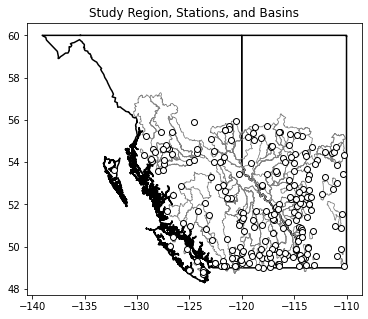

In [56]:
#visualize study region
fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'gray', linewidth = 0.75)
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', zorder = 3)
ax.set_title('Study Region, Stations, and Basins')

plt.show()

In [31]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [32]:
#standardize data relative to training time period

#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

In [33]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_val = np.empty((Nval, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,), dtype = np.float16)
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#training
for ii in range(Ntrain-365):
  x_train[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)
x_train = tf.convert_to_tensor(x_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)
y_train = tf.convert_to_tensor(y_train)

In [34]:
# ALTERNATIVE:  Data can be structured as a generator which creates the input from x_intermediate.
#               Generators can be used when data cannot be loaded directly into RAM.  Memory issues
#               can come up especially from the multi-dimensional video structure.  We did not use
#               the generator approach here; rather, we loaded input/output directly to memory.  An
#               example of how to setup and train from generators is provided here.

# #training generator
# def gen_train():
#   for ii in range(Ntrain-365):
#     xx = tf.convert_to_tensor(x_intermediate[ii:ii+365])
#     yy = Fnorm[365+ii,:]
#     yield xx,yy

# #validation generator
# def gen_val():
#   for ii in range(Nval):
#     xx = tf.convert_to_tensor(x_intermediate[ii + Ntrain - 365 : ii + Ntrain])
#     yy = Fnorm[valInds[ii],:]
#     yield xx,yy

# #testing generator
# def gen_test():
#   for ii in range(Ntest):
#     xx = tf.convert_to_tensor(x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval])
#     yy = Fnorm[testInds[ii],:]
#     yield xx,yy

# #define datasets from these generators

# batch_size = 64

# train_dataset = tf.data.Dataset.from_generator(
#     gen_train,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Ntrain).batch(batch_size)

# val_dataset = tf.data.Dataset.from_generator(
#     gen_val,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Nval).batch(batch_size)

# test_dataset = tf.data.Dataset.from_generator(
#     gen_test,
#     (tf.float16, tf.float16),
#     (tf.TensorShape([365,12,32,3]), tf.TensorShape([226]))
#     ).shuffle(Ntest).batch(batch_size)

# #Example of use for training:

# callbacks = EarlyStopping(monitor='val_loss', 
#                         mode='min', 
#                         verbose=1, 
#                         patience = 5,
#                         restore_best_weights = True)

# model_bulk = build_bulk_model(learning_rate = 1e-4)
# model_bulk.fit(
#     train_dataset,
#     validation_data = val_dataset,
#     epochs = 200,
#     verbose = 1, 
#     callbacks = [callbacks]
#     )

# Cluster seasonal flow

In [35]:
#create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

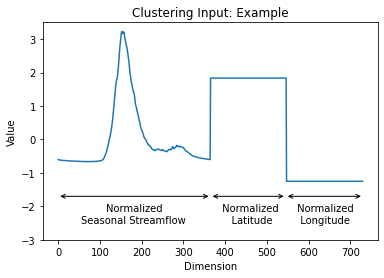

In [36]:
#visualize single input

saveIt = 0

fig, ax = plt.subplots()

ax.plot(cluster_input[0])
ax.set_xlabel('Dimension')
ax.set_ylabel('Value')
ax.set_title('Clustering Input: Example')
ax.set_ylim([-3,3.5])

p1 = [0, -1.7]
p2 = [365, -1.7]
pmid12 = np.mean([p1, p2])

p3 = [545, -1.7]
pmid23 = np.mean([p2,p3])

p4 = [730, -1.7]
pmid34 = np.mean([p3,p4])

plt.annotate(s='', xy=(p2[0],p2[1]), xytext=(p1[0],p1[1]), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(p3[0],p3[1]), xytext=(p2[0],p2[1]), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(p4[0],p4[1]), xytext=(p3[0],p3[1]), arrowprops=dict(arrowstyle='<->'))

ax.text(x = 55, y = -2.5, s = '        Normalized \nSeasonal Streamflow', fontsize = 10)
ax.text(x = 385, y = -2.5, s = ' Normalized \n    Latitude', fontsize = 10)
ax.text(x = 565, y = -2.5, s = ' Normalized \n  Longitude', fontsize = 10)

if saveIt:
  plt.savefig('clustering_input_example.png', bbox_inches = 'tight', dpi = 300)

plt.show()

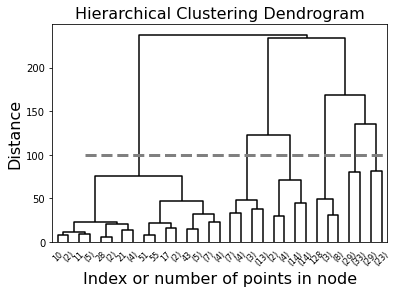

In [37]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Index or number of points in node", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [38]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [39]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern'
]

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

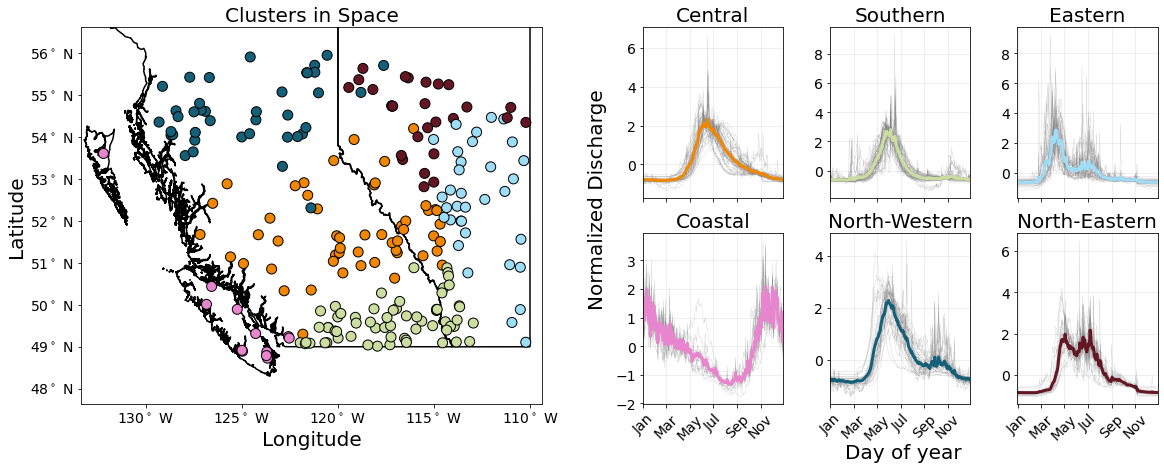

In [40]:
#visualize clustering results (spatial + temporal patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig = plt.figure(figsize = (16,7))

#left side: spatial map of stations, coloured by cluster to which they belong
ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-6)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))

#right side: subplots of seasonal streamflow of each cluster 
subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

ax0.text(-107,50, 'Normalized Discharge', fontsize = fs, rotation = 90) #manually add axis labels to control tight-layout aesthetic 
ax0.text(-93.6,46.35, 'Day of year', fontsize = fs)

#edit ticklabels
xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax0.get_xticklabels()]
ax0.set_xticklabels(xtls)
ytls = [item.get_text() + '$^\circ$ N' for item in ax0.get_yticklabels()]
ax0.set_yticklabels(ytls)

if saveIt:
  plt.savefig('cluster_patterns.png', bbox_inches = 'tight', dpi = 300)

if saveEPS:
  plt.savefig('cluster_patterns.eps', format = 'eps', bbox_inches='tight')

plt.show()

# Train bulk and fine-tuned models

In [ ]:
#set of random seeds to use for reproducability
seeds = [00, 11, 22, 33, 44, 55, 66, 77, 88, 99]

#parameters for training
learning_rate = 1e-4

#parameters for heat maps
sigma = 1.5 #radius of perturbation
style_dict = {'style' : 'gauss', #style of perturbation: gaussian (not RISE/rectangular)
              'params' : sigma}
days_heat = range(Ntest) #days in test set to perturb
iters_total = 200 #total iterations of perturbation
iters_one_pass = 50 #number of iterations to pass through model at one time (too high --> RAM issues)
tol = 5e-3

#for each random seed (one seed = one bulk / set of fine-tuned models; 10 seeds --> 10 model ensemble)
for ii, s in enumerate(seeds):

##### BULK 

  print('Training bulk model ' + str(ii+1) + ' / ' + str(len(seeds)))

  #set random seeds
  seed(s)
  np.random.seed(s)
  tf.random.set_seed(s)

  #define early stopping callback to use in all models
  callbacks = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          verbose=1, 
                          patience = 5,
                          restore_best_weights = True)

  #create train/val/test datasets for bulk model
  batch_size = 64
  train_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(Ntrain).batch(batch_size)
  val_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(Nval).batch(batch_size)
  test_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(Ntest).batch(batch_size)

  #generate/train bulk model
  model_bulk = build_bulk_model(learning_rate = learning_rate)
  model_bulk.fit(
    train_dataset_bulk,
    validation_data = val_dataset_bulk,
    epochs = 200,
    verbose = 0, 
    callbacks = [callbacks]
    )

  #predict train/val/test streamflow
  y_train_predict_bulk = model_bulk.predict(x_train, batch_size = batch_size, verbose = 0)
  y_val_predict_bulk = model_bulk.predict(x_val, batch_size = batch_size, verbose = 0)
  y_test_predict_bulk = model_bulk.predict(x_test, batch_size = batch_size, verbose = 0)

  #save bulk model outputs
  file_train = 'y_train_bulk_predict_' + str(ii) + '.csv' #ii is the model number
  file_val = 'y_val_bulk_predict_' + str(ii) + '.csv'
  file_test = 'y_test_bulk_predict_' + str(ii) + '.csv'

  np.savetxt(dir_output + '/' + file_train, y_train_predict_bulk, delimiter = ',')
  np.savetxt(dir_output + '/' + file_val, y_val_predict_bulk, delimiter = ',')
  np.savetxt(dir_output + '/' + file_test, y_test_predict_bulk, delimiter = ',')

  #save bulk model
  model_name = 'model_bulk_' + str(ii) + '.h5'
  model_bulk.save(dir_models + '/' + model_name)

  #generate/save bulk heat maps
  print(' Making sensitivity heat maps')
  heat_mean_bulk = make_heat(
      model = model_bulk, 
      x_test = x_test, 
      y_test = y_test, 
      style_dict = style_dict, 
      days = days_heat, 
      iters_total = iters_total, 
      iters_one_pass = iters_one_pass, 
      stationInds = range(len(stationInds)),
      verbose = 0,
      tol = tol
      )
  fileName = 'heat_mean_bulk_' + str(ii) + '.csv'
  np.savetxt(dir_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

##### FINE-TUNING

  #prep fine-tune target output
  y_train_predict_fine_all = np.empty_like(y_train)
  y_val_predict_fine_all = np.empty_like(y_val)
  y_test_predict_fine_all = np.empty_like(y_test)

  #for each streamflow cluster, make/train/save fine-tuned model/output/heatmaps  
  heat_mean_fine = np.zeros_like(heat_mean_bulk)
  for cluster in range(n_clusters_seasonal):

    print('Training fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster
    
    #create target datasets (note: x is the same, y is different (same spatial input, different station targets))
    y_train_fine_current = tf.convert_to_tensor(y_train.numpy()[:,stations_fine])
    y_val_fine_current = tf.convert_to_tensor(y_val.numpy()[:,stations_fine])
    y_test_fine_current = tf.convert_to_tensor(y_test.numpy()[:,stations_fine])

    train_dataset_fine = tf.data.Dataset.from_tensor_slices((x_train,y_train_fine_current)).shuffle(Ntrain).batch(batch_size = batch_size)
    val_dataset_fine = tf.data.Dataset.from_tensor_slices((x_val,y_val_fine_current)).shuffle(Nval).batch(batch_size = batch_size)

    #build and train fine-tuned model
    model_fine = build_fine_model(model_bulk = model_bulk, N_stations = N_stations, learning_rate = learning_rate)
    model_fine.fit(
      train_dataset_fine,
      validation_data = val_dataset_fine,
      epochs = 200,
      verbose = 0, 
      callbacks = [callbacks]
      )

    #predict train/val/test streamflow
    y_train_predict_fine = model_fine.predict(x_train, batch_size = batch_size, verbose = 0)
    y_val_predict_fine = model_fine.predict(x_val, batch_size = batch_size, verbose = 0)
    y_test_predict_fine = model_fine.predict(x_test, batch_size = batch_size, verbose = 0)

    #reorganize predictions into array that matches the bulk train/val/test structure
    for kk, station_fine in enumerate(stations_fine): #for each station/index in this cluster
      y_train_predict_fine_all[:,station_fine] = y_train_predict_fine[:,kk] #y_***_predict_fine_all has fine-tuned predictions for all stations, in same order as bulk
      y_val_predict_fine_all[:,station_fine] = y_val_predict_fine[:,kk]
      y_test_predict_fine_all[:,station_fine] = y_test_predict_fine[:,kk]

    #save model 
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine.save(dir_models + '/' + model_name)

    #generate fine-tuned heat maps
    print(' Making sensitivity heat maps')
    heat_mean_cluster = make_heat(
        model = model_fine, 
        x_test = x_test, 
        y_test = y_test, 
        style_dict = style_dict, 
        days = days_heat, 
        iters_total = iters_total, 
        iters_one_pass = iters_one_pass, 
        stationInds = stations_fine,
        verbose = 0,
        tol = tol
        )
    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
      heat_mean_fine[:,station] = heat_mean_cluster[:,zz]

    #save the in-progress heatmaps in case of crash
    fileName = 'heat_mean_fine_' + str(ii) + '_cluster_' + str(cluster) + '_inprogess.csv'
    np.savetxt(dir_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

  #save fine-tuned heatmaps
  fileName = 'heat_mean_fine_' + str(ii) + '.csv'
  np.savetxt(dir_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

  #save fine-tuned model predictions
  file_train = 'y_train_fine_predict_' + str(ii) + '.csv'
  file_val = 'y_val_fine_predict_' + str(ii) + '.csv'
  file_test = 'y_test_fine_predict_' + str(ii) + '.csv'

  np.savetxt(dir_output + '/' + file_train, y_train_predict_fine_all, delimiter = ',')
  np.savetxt(dir_output + '/' + file_val, y_val_predict_fine_all, delimiter = ',')
  np.savetxt(dir_output + '/' + file_test, y_test_predict_fine_all, delimiter = ',')


# Ensemble analysis: All runs

In [42]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#initialize
NSE_fine_runs = np.empty((len(runs), len(stationInds))) #fine-tuned NSE on test set
NSE_bulk_runs = np.empty((len(runs), len(stationInds))) #bulk NSE on test set
dNSE_runs = np.empty((len(runs), len(stationInds))) #difference in NSE from fine-tuning

A_fine_runs = np.empty((len(runs), len(stationInds))) #A from fine-tuned heatmaps on test set
A_bulk_runs = np.empty((len(runs), len(stationInds))) #A from bulk heatmaps on test set
dA_runs = np.empty((len(runs), len(stationInds))) #difference in A from fine-tuning

heat_mean_fine_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #fine-tuned heatmaps of each run
heat_mean_bulk_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #bulk heatmaps of each run

y_test_predict_bulk_runs = np.empty((len(runs), Ntest, len(stationInds))) #bulk model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  #load modelled streamflow
  filename_train_bulk = 'y_train_bulk_predict_' + str(run) + '.csv'
  filename_val_bulk = 'y_val_bulk_predict_' + str(run) + '.csv'
  filename_test_bulk = 'y_test_bulk_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
  y_train_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_train_bulk, header = None))
  y_val_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_val_bulk, header = None))
  y_test_predict_bulk = np.asarray(pd.read_csv(dir_output + '/' + filename_test_bulk, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))
  y_test_predict_bulk_runs[ii,:,:] = y_test_predict_bulk
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine
  y_all_predict_fine_runs[ii,:,:] = np.vstack((y_train_predict_fine, y_val_predict_fine, y_test_predict_fine))

  #load heat maps
  filename_bulk = 'heat_mean_bulk_' + str(run) + '.csv'
  filename_fine = 'heat_mean_fine_' + str(run) + '.csv'
  heat_mean_bulk = np.asarray(pd.read_csv(dir_heat + '/' + filename_bulk, header = None))
  heat_mean_fine = np.asarray(pd.read_csv(dir_heat + '/' + filename_fine, header = None))
  heat_mean_bulk_runs[ii,:,:] = heat_mean_bulk
  heat_mean_fine_runs[ii,:,:] = heat_mean_fine

  #initialize NSE train/val/test bulk/fine and A bulk/fine arrays of this current run
  NSE_fine = np.empty((len(stationInds),))
  NSE_bulk = np.empty((len(stationInds),))
  NSE_train_fine = np.empty((len(stationInds),))
  NSE_train_bulk = np.empty((len(stationInds),))
  NSE_val_fine = np.empty((len(stationInds),))
  NSE_val_bulk = np.empty((len(stationInds),))
  NSE_test_fine = np.empty((len(stationInds),))
  NSE_test_bulk = np.empty((len(stationInds),))
  A_fine = np.zeros((len(stationInds),))
  A_bulk= np.zeros((len(stationInds),))

  #loop through each station and calculate NSE and A
  for station in range(len(stationInds)):

#####calculate NSE

    #calculate train/val/test on fine/bulk models -- we'll use test NSE for evaluation but calculate all for interest sake
    NSE_train_fine[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_fine[:,station]
        )
    NSE_val_fine[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_fine[:,station]
        )
    NSE_test_fine[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_fine[:,station]
        )
    NSE_train_bulk[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_bulk[:,station]
        )
    NSE_val_bulk[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_bulk[:,station]
        )
    NSE_test_bulk[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_bulk[:,station]
        )

#####calculate A
    A_bulk[station] = get_A(heat = heat_mean_bulk[:,station])
    A_fine[station] = get_A(heat = heat_mean_fine[:,station])

  dNSE = NSE_test_fine - NSE_test_bulk
  dA = A_fine - A_bulk

  NSE_fine_runs[ii,:] = np.asarray(NSE_test_fine)
  NSE_bulk_runs[ii,:] = np.asarray(NSE_test_bulk)
  dNSE_runs[ii,:] = dNSE

  A_fine_runs[ii,:] = A_fine
  A_bulk_runs[ii,:] = A_bulk
  dA_runs[ii,:] = dA

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [43]:
#also calculate NSE of the model ensemble average streamflow, rather than model-by-model NSE

NSE_bulk = np.empty(len(stationInds))
NSE_fine = np.empty(len(stationInds))

for station in range(len(stationInds)):

  NSE_bulk[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_bulk_runs,axis = 0)[:,station]
  )

  NSE_fine[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_fine_runs,axis = 0)[:,station]
  )

print('NSE test bulk ensemble = ' + str(np.round(np.median(NSE_bulk), decimals = 2)))
print('NSE test fine ensemble = ' + str(np.round(np.median(NSE_fine), decimals = 2)))

NSE test bulk ensemble = 0.66
NSE test fine ensemble = 0.68


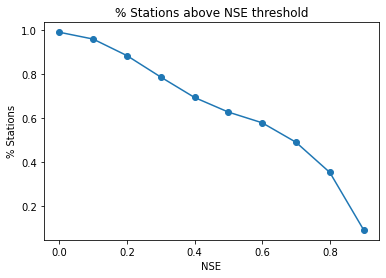

In [44]:
#find % of stations with NSE > threshold (particularly, NSE > 0.8)
thresholds = np.arange(0,1,0.1)
frac = [len(np.argwhere(NSE_fine > threshold))/226 for threshold in thresholds]

plt.plot(thresholds, frac)
plt.scatter(thresholds, frac)
plt.title('% Stations above NSE threshold')
plt.xlabel('NSE')
plt.ylabel('% Stations')
plt.show()

In [45]:
#normalize each heat maps to have zero mean and unity variance -- want to compare spatial form of sensitivity

#initialize
heat_mean_fine_runs_norm = np.zeros_like(heat_mean_fine_runs)
heat_mean_bulk_runs_norm = np.zeros_like(heat_mean_bulk_runs)

#for each station and run, load/normalize each bulk/fine heat map
for station in range(len(stationInds)):
  for run in range(len(runs)):

    hh = heat_mean_fine_runs[run,:,station]
    heat_mean_fine_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

    hh = heat_mean_bulk_runs[run,:,station]
    heat_mean_bulk_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

#calculate ensemble mean heat map for each station
heat_fine_ensemble_mean = heat_mean_fine#heat_mean_fine_runs_norm[0]#
heat_fine_ensemble_mean = np.mean(heat_mean_fine_runs_norm, axis = 0)
heat_bulk_ensemble_mean = np.mean(heat_mean_bulk_runs_norm, axis = 0)

cluster_heat_fine_mean = []
cluster_heat_bulk_mean = []

#calculate ensemble mean heat map for each cluster
for cluster in range(n_clusters_seasonal):

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1) #indices of the cluster

  cluster_heat_mean_fine_current = np.squeeze(np.mean(heat_fine_ensemble_mean[:,inds], axis = 1))
  cluster_heat_mean_bulk_current = np.squeeze(np.mean(heat_bulk_ensemble_mean[:,inds], axis = 1))
  
  cluster_heat_fine_mean.append(cluster_heat_mean_fine_current)
  cluster_heat_bulk_mean.append(cluster_heat_mean_bulk_current)

In [46]:
#calculate sensitive areas on ensemble mean heat maps
A_fine = np.zeros((len(stationInds),))
A_bulk= np.zeros((len(stationInds),))

for station in range(len(stationInds)):
  A_bulk[station] = get_A(heat = heat_bulk_ensemble_mean[:,station])
  A_fine[station] = get_A(heat = heat_fine_ensemble_mean[:,station])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


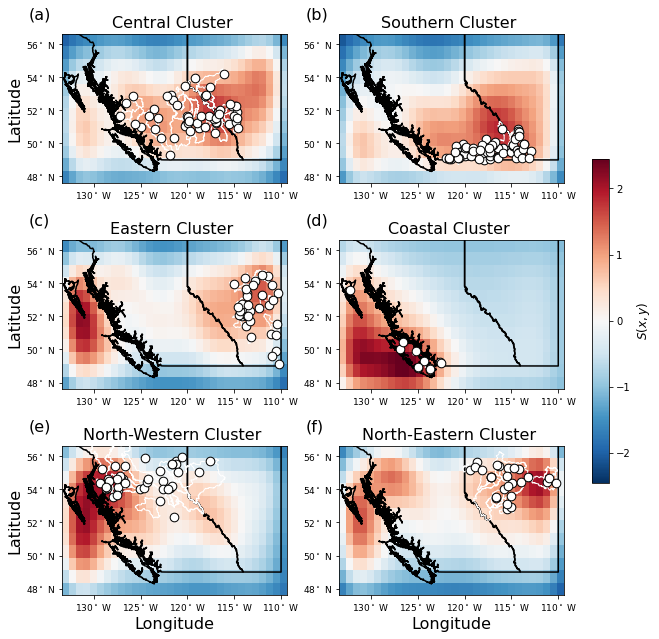

In [47]:
#visualize fine-tuned ensemble mean heatmaps for each cluster

saveIt = 0
saveEPS = 0

fs = 16
abc = ['(a)','(b)','(c)','(d)','(e)','(f)']

nrows = 3
ncols = 2

vmax = np.max(np.abs(cluster_heat_fine_mean))
vmin = -vmax#np.min(cluster_heat_fine_mean)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols,3*nrows))

for cluster, ax in enumerate(axes.flatten()): #for each cluster

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1) #indices of stations in this cluster
  im = ax.imshow(cluster_heat_fine_mean[cluster].reshape(np.shape(Tmax[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)

  #plot the basin of each cluster overtop of the heatmap
  for ind in inds:
    basin = stationBasins[ind[0]]
    if basin is not None:
      x,y = basin.exterior.xy
      ax.plot(x,y,'w', linewidth = 1, zOrder = 3)

  ax.scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4) #stream gauge stations
  plot_prov_ax(prov = prov, ax = ax) #provincial borders
  
  ax.tick_params(labelsize = fs-4)
  if cluster == 4 or cluster == 5:
    ax.set_xlabel('Longitude', fontsize = fs)
  if cluster == 0 or cluster == 2 or cluster == 4:
    ax.set_ylabel('Latitude', fontsize = fs)

  ax.set_title(cluster_names[cluster] + ' Cluster ', fontsize = fs)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))
  ax.text(x = -0.15, y = 1.1, s = abc[cluster], transform = ax.transAxes, fontsize = fs)

cax = fig.add_axes([1.01, 0.25, 0.03, 0.5]) #colourbar gets own axis
mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)
cb = fig.colorbar(im, cax = cax, orientation = 'vertical')
plt.ylabel('$S(x,y)$', fontsize = fs-4)#, cax)

plt.tight_layout()

#edit ticklabels to degrees W and N
for ax in axes.flatten():
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls, fontsize = 9)

  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls, fontsize = 9)

if saveIt:
  plt.savefig('ensemble_mean_fine_sensitivity.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('ensemble_mean_fine_sensitivity.eps', format = 'eps', bbox_inches='tight')

In [48]:
#calculate kolmogorov-smirnov D-statistic for each bulk/fine run, and bulk/fine ensembles

#initialize
ks_bulk = np.zeros((len(runs), n_clusters_seasonal))
ks_fine = np.zeros((len(runs), n_clusters_seasonal))

p_bulk = np.zeros((len(runs), n_clusters_seasonal))
p_fine = np.zeros((len(runs), n_clusters_seasonal))

heat_in_clusters_bulk = [None] * len(runs)
heat_in_clusters_fine = [None] * len(runs)

heat_out_clusters_bulk = [None] * len(runs)
heat_out_clusters_fine = [None] * len(runs)

unique_in_clusters_bulk = [None] * len(runs)
unique_in_clusters_fine = [None] * len(runs)


#for each run, calculate D-stat for bulk/fine heat maps
for run_ind in range(len(runs)):
  
  #calculate ks for bulk
  data = heat_mean_bulk_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_bulk[run_ind,:], p_bulk[run_ind,:], heat_in_clusters_bulk[run_ind], heat_out_clusters_bulk[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

  #calculate ks for fine
  data = heat_mean_fine_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_fine[run_ind,:], p_fine[run_ind,:], heat_in_clusters_fine[run_ind], heat_out_clusters_fine[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for bulk ensemble mean heat map
data = heat_bulk_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_bulk_ensemble, p_bulk_ensemble, heat_in_clusters_bulk_ensemble, heat_out_clusters_bulk_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for fine-tuned ensemble mean heat map
data = heat_fine_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_fine_ensemble, p_fine_ensemble, heat_in_clusters_fine_ensemble, heat_out_clusters_fine_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

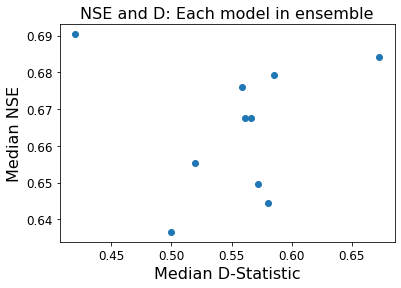

In [49]:
#are NSE and D (K-S statistic) related?

x = np.median(ks_fine, axis = 1)
y = np.median(NSE_fine_runs, axis = 1)

fs = 16

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('Median D-Statistic', fontsize = fs)
ax.set_ylabel('Median NSE', fontsize = fs)
ax.set_title('NSE and D: Each model in ensemble', fontsize = fs)
ax.tick_params(labelsize = fs - 4)

plt.show()

In [50]:
r,p = pearsonr(x,y)
rangeD = np.max(x) - np.min(x)
rangeNSE = np.max(y) - np.min(y)

print('NSE and D for each model run have correlation coefficient: ' + str(np.round(r, decimals = 2)))
print('with p-value: ' + str(np.round(p, decimals = 2)))
print('')
print('Range of D: ' + str(np.round(rangeD, decimals = 2)))
print('Range of NSE: '  + str(np.round(rangeNSE, decimals = 2)))


NSE and D for each model run have correlation coefficient: 0.05
with p-value: 0.9

Range of D: 0.25
Range of NSE: 0.05


# Response to $\Delta$T

In [153]:
del x_train, x_val #delete to free up memory

In [155]:
#FINE-TUNED: warm/cold perturbations on all clusters

dT_K = 5. #number of degrees by which to perturb the temperature fields (Kelvin)
dTmin = dT_K / Tminstd_train #normalized temp for min-temp channel perturbation
dTmax = dT_K / Tmaxstd_train #normalized temp for max-temp channel perturbation
N_dT = 11 #number of perturbations

heat_increments_min = np.linspace(dTmin, -dTmin, N_dT) #min temp perturbations
heat_increments_max = np.linspace(dTmax, -dTmax, N_dT) #max temp perturbations

#initialize
y_test_warmcold_clusters_fine = np.zeros((n_clusters_seasonal, N_dT, 365)) #cluster-average modelled seasonal streamflow for each perturbation
y_test_warmcold_all = np.zeros((N_dT, Ntest, len(stationInds))) #each station's modelled streamflow for each perturbation; run x station x increment x days

#loop through each cluster, perturbation, and model run: perturb input, predict streamflow
for cluster in range(n_clusters_seasonal): #for each cluster

  print('Cluster: ' + str(cluster + 1) + '/' + str(n_clusters_seasonal))

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
  y_test_warmcold = np.empty((N_dT, Ntest, len(inds)))

  for jj in range(N_dT): #for each perturbation

    tt = heat_increments_min[jj] #amount to perturb min temp by
    TT = heat_increments_max[jj] #amount to perturb max temp by
    
    print('   Perurbation: ' + str(jj+1) + '/' + str(N_dT))

    x_test_warmcold = tf.identity(x_test).numpy() #regular input
    x_test_warmcold[:,:,:,:,:2] = x_test.numpy()[:,:,:,:,:2] + [TT,tt] #perturbed input
    x_test_warmcold = tf.convert_to_tensor(x_test_warmcold) #tensor perturbed input

    y_test_warmcold_runs = np.empty((len(runs), Ntest, len(inds)))
    for ii, run in enumerate(runs): #for each run
      model = tf.keras.models.load_model(dir_models + '/model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5') #load model
      y_test_warmcold_runs[ii,:,:] = model.predict(x_test_warmcold, batch_size = 64, verbose = 0) #predict streamflow
    
    y_test_warmcold[jj,:,:] = np.mean(y_test_warmcold_runs, axis = 0) #ensemble mean predicted streamflow

    del x_test_warmcold, model

    print(hpy().heap()) #can print this to check memory

  #calculate average seasonal flow, as evaluated over the test period and at all stations in each cluster
  y_test_warmcold_cluster = np.mean(y_test_warmcold, axis = -1) #cluster average predicted streamflow
  for ii, station in enumerate(inds): #for each station
    y_test_warmcold_all[:,:,station] = y_test_warmcold[:,:,ii] #store predicted streamflow at corresponding index

  #average seasonal flow over test period
  yy = np.zeros((N_dT,365))
  for kk in range(int(np.round(Ntest/365))):
    yy += y_test_warmcold_cluster[:,kk*365:(kk+1)*365]
  yy /= np.round(Ntest/365)

  y_test_warmcold_clusters_fine[cluster,:,:] = yy 

Cluster: 1/6
   Perurbation: 1/11
   Perurbation: 2/11
   Perurbation: 3/11
   Perurbation: 4/11
   Perurbation: 5/11
   Perurbation: 6/11
   Perurbation: 7/11
   Perurbation: 8/11
   Perurbation: 9/11
   Perurbation: 10/11
   Perurbation: 11/11
Cluster: 2/6
   Perurbation: 1/11
   Perurbation: 2/11
   Perurbation: 3/11
   Perurbation: 4/11
   Perurbation: 5/11
   Perurbation: 6/11
   Perurbation: 7/11
   Perurbation: 8/11
   Perurbation: 9/11
   Perurbation: 10/11
   Perurbation: 11/11
Cluster: 3/6
   Perurbation: 1/11
   Perurbation: 2/11
   Perurbation: 3/11
   Perurbation: 4/11
   Perurbation: 5/11
   Perurbation: 6/11
   Perurbation: 7/11
   Perurbation: 8/11
   Perurbation: 9/11
   Perurbation: 10/11
   Perurbation: 11/11
Cluster: 4/6
   Perurbation: 1/11
   Perurbation: 2/11
   Perurbation: 3/11
   Perurbation: 4/11
   Perurbation: 5/11
   Perurbation: 6/11
   Perurbation: 7/11
   Perurbation: 8/11
   Perurbation: 9/11
   Perurbation: 10/11
   Perurbation: 11/11
Cluster: 5/6
   

In [156]:
# #average seasonal flow over test period
# y_test_warmcold_fine = np.zeros((len(stationInds), N_dT, 365))
# for station in range(len(stationInds)):
#   yy = np.zeros((N_dT,365))
#   for kk in range(int(np.round(Ntest/365))):
#     yy += y_test_warmcold_all[:, kk*365:(kk+1)*365, station]
#   yy /= np.round(Ntest/365)
#   y_test_warmcold_fine[station,:,:] = yy

# window_smooth = 30 #window to use for rolling average of temperature to smooth to find zero-crossings
# y_test_warmcold_fine_smooth = np.zeros_like(y_test_warmcold_fine)
# for hh, heat_increment in enumerate(heat_increments_min):
#   for station in range(len(stationInds)):
#     y_test_warmcold_fine_smooth[station, hh, :] = pd.Series(y_test_warmcold_fine[station,hh,:]).rolling(window = window_smooth, center = False, min_periods = 0).mean()


In [157]:
#find when temperatures are below/above 0
#for each perturbation in heat_increments_max/min:
#want: day of year where each cluster, on average shifts from below 0 to above 0 (max and min temp separately)
#need: temperature time series for each pixel: temperature vs day for each pixel
#then: average out over all pixels in each cluster
#then: calculate average temp vs time series over test period (seasonal average temp vs time for each pixel)
#then: calculate 0-crossings
#find minimum temperature

#first: minimum temperature

window_smooth = 30 #window to use for rolling average of temperature to smooth to find zero-crossings
Tmin_zero_crossings_all = np.zeros((len(heat_increments_min), n_clusters_seasonal))
Tmin_seasonal_all = np.zeros((n_clusters_seasonal, N_dT, 365))

for hh, heat_increment in enumerate(heat_increments_min):

  #smooth temperature 
  Tmin_test = Tmin[testInds,:,:] + heat_increment * Tminstd_train #in Kelvin
  Tmin_test_smooth = np.zeros_like(Tmin_test)
  for ii in range(np.shape(Tmin_test[0,:,:])[0]): #for each lat
    for jj in range(np.shape(Tmin_test[0,:,:])[1]): #for each lon
      Tmin_test_smooth[:,ii,jj] = pd.Series(Tmin_test[:,ii,jj]).rolling(window = window_smooth, center = False, min_periods = 0).mean() #smooth temperature series

  #calculate mean temperature series of cluster region time series
  Tmin_clusters = [None] * n_clusters_seasonal
  for cluster in range(n_clusters_seasonal): #for each cluster
    kk = 0
    Tmin_cluster = np.zeros_like(Tmin_test_smooth[:,0,0])
    for ii in range(np.shape(Tmin_test[0,:,:])[0]): #for each lat
      for jj in range(np.shape(Tmin_test[0,:,:])[1]): #for each lon
        if kk in unique_in_clusters[cluster]: #if index is within/near this cluster's region
          Tmin_cluster += Tmin_test_smooth[:,ii,jj] #add temp time series to the cluster's temp time series
        kk+=1
    Tmin_cluster /= len(unique_in_clusters[cluster]) #divide temp time series by number of pixels -- this gives the average
    Tmin_clusters[cluster] = Tmin_cluster 

  #calculate seasonal temperature of cluster region (over years in test set)
  for cluster in range(n_clusters_seasonal): #for each cluster
    tt = np.zeros(365,)
    for kk in range(int(np.round(Ntest/365))): #for each year in test set
      tt += Tmin_clusters[cluster][kk*365 : (kk+1)*365]
    tt /= (kk+1)
    Tmin_clusters[cluster] = tt
    Tmin_seasonal_all[cluster, hh, :] = tt

  #evaluate when transition from below 0 to above 0 happens
  first_zero_crossing_clusters = np.zeros(n_clusters_seasonal) 
  for cluster in range(n_clusters_seasonal): #for each cluster
    zero_crossings = np.where(np.diff(np.sign(Tmin_clusters[cluster] - 273))) #zero crossing is where sign changes (in celsius)
    if np.size(zero_crossings[0]) > 1: #if more than one zero crossing (e.g. spring and fall: likely multiple days in spring from temp flucuations and multiple days in fall from temp fluctuations)
      dzs = zero_crossings[0][1:] - zero_crossings[0][:-1] #difference in days between zero crossings
      ind_dzmax = np.argmax(dzs) #index of largest gap between zero crossings: this is difference between spring set of zero crossings and fall set of zero crossings
      first_zero_crossing_clusters[cluster] = np.mean(zero_crossings[0][:ind_dzmax+1]) #take average of spring set of zero crossings

  Tmin_zero_crossings_all[hh,:] = first_zero_crossing_clusters

In [158]:
#now: maximum temperature

Tmax_zero_crossings_all = np.zeros((len(heat_increments_min), n_clusters_seasonal))
Tmax_seasonal_all = np.zeros((n_clusters_seasonal, N_dT, 365))

for hh, heat_increment in enumerate(heat_increments_max):

  #smooth temperature 
  Tmax_test = Tmax[testInds,:,:] + heat_increment * Tmaxstd_train
  Tmax_test_smooth = np.zeros_like(Tmax_test)
  for ii in range(np.shape(Tmax_test[0,:,:])[0]): #for each lat
    for jj in range(np.shape(Tmax_test[0,:,:])[1]): #for each lon
      Tmax_test_smooth[:,ii,jj] = pd.Series(Tmax_test[:,ii,jj]).rolling(window = window_smooth, center = False, min_periods = 0).mean() #smooth temperature series

  #calculate mean temperature of cluster region time series
  Tmax_clusters = [None] * n_clusters_seasonal
  for cluster in range(n_clusters_seasonal): #for each cluster
    kk = 0
    Tmax_cluster = np.zeros_like(Tmax_test_smooth[:,0,0])
    for ii in range(np.shape(Tmax_test[0,:,:])[0]): #for each lat
      for jj in range(np.shape(Tmax_test[0,:,:])[1]): #for each lon
        if kk in unique_in_clusters[cluster]: #if index is within/near this cluster's region
          Tmax_cluster += Tmax_test_smooth[:,ii,jj] #add temp time series to the cluster's temp time series
        kk+=1
    Tmax_cluster /= len(unique_in_clusters[cluster]) #divide temp time series by number of pixels -- this gives the average
    Tmax_clusters[cluster] = Tmax_cluster

  #calculate mean yearly temperature of cluster region
  for cluster in range(n_clusters_seasonal): #for each cluster
    tt = np.zeros(365,)
    for kk in range(int(np.round(Ntest/365))): #foe each year in test set
      tt += Tmax_clusters[cluster][kk*365 : (kk+1)*365]
    tt /= (kk+1)
    Tmax_clusters[cluster] = tt
    Tmax_seasonal_all[cluster, hh, :] = tt

  #evaluate when transition from below 0 to above 0 happens
  first_zero_crossing_clusters = np.zeros(n_clusters_seasonal)
  for cluster in range(n_clusters_seasonal):
    zero_crossings = np.where(np.diff(np.sign(Tmax_clusters[cluster] - 273))) #zero crossing is where sign changes (in celsius)
    if np.size(zero_crossings[0]) > 1: #if more than one zero crossing (e.g. spring and fall: likely multiple days in spring from temp flucuations and multiple days in fall from temp fluctuations)
      dzs = zero_crossings[0][1:] - zero_crossings[0][:-1] #difference in days between zero crossings
      ind_dzmax = np.argmax(dzs) #index of largest gap between zero crossings: this is difference between spring set of zero crossings and fall set of zero crossings
      first_zero_crossing_clusters[cluster] = np.mean(zero_crossings[0][:ind_dzmax+1]) #take average of spring set of zero crossings

  Tmax_zero_crossings_all[hh,:] = first_zero_crossing_clusters

In [159]:
#smooth y_test_warmcold
window_smooth = 30 #window to use for rolling average of temperature to smooth to find zero-crossings
y_test_warmcold_clusters_fine_smooth = np.zeros_like(y_test_warmcold_clusters_fine)
for hh, heat_increment in enumerate(heat_increments_min):
  for cluster in range(n_clusters_seasonal):
    y_test_warmcold_clusters_fine_smooth[cluster, hh, :] = pd.Series(y_test_warmcold_clusters_fine[cluster,hh,:]).rolling(window = window_smooth, center = False, min_periods = 0).mean()


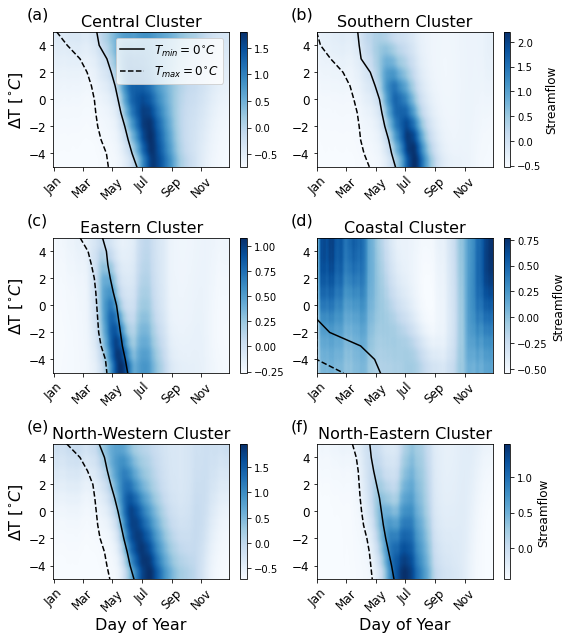

In [161]:
saveIt = 0
saveEPS = 0

extent = [0, 365, -dT_K, dT_K]
fs = 16
abc = ['(a)','(b)','(c)','(d)','(e)','(f)']

nrows = 3
ncols = 2

fix, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols,3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  im = ax.imshow(y_test_warmcold_clusters_fine_smooth[cluster,:,:], aspect = 'auto', extent = extent, cmap = 'Blues')
  cb = fig.colorbar(im, ax = ax)
  ax.plot(Tmin_zero_crossings_all[:,cluster], np.linspace(dT_K,-dT_K,N_dT), 'k', label = '$T_{min} = 0^{\circ}C$')
  ax.plot(Tmax_zero_crossings_all[:,cluster], np.linspace(dT_K,-dT_K,N_dT), 'k--', label = '$T_{max} = 0^{\circ}C$')
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')

  if cluster == 0:
    ax.legend(fontsize = 12)

  if np.mod(cluster,2)==0: #if even, label y
    ax.set_ylabel('\u0394T [$^{\circ}C$]', fontsize = fs)
  else: #if odd, label colorbar
    cb.ax.set_ylabel('Streamflow', fontsize = fs-4)
  
  if (cluster == 4) or (cluster == 5): #if bottom, label x
    ax.set_xlabel('Day of Year', fontsize = fs)

  ax.set_title(cluster_names[cluster] + ' Cluster', fontsize = fs)
  ax.tick_params(labelsize = fs - 4)
  ax.text(x = -0.15, y = 1.1, s = abc[cluster], transform = ax.transAxes, fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('freshet_track_fine.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('freshet_track_fine.eps', format = 'eps', bbox_inches='tight')

In [162]:
#calculate day of peak freshet flow
#calculate day of half-peak freshet flow

q_peak = np.zeros((n_clusters_seasonal, N_dT))
t_peak = np.zeros((n_clusters_seasonal, N_dT))
t_half = np.zeros((n_clusters_seasonal, N_dT))
dtpeak_dT = np.zeros(n_clusters_seasonal)
dthalf_dT = np.zeros(n_clusters_seasonal)
dtzero_dT = np.zeros(n_clusters_seasonal)

for cluster in range(n_clusters_seasonal):
  for hh in range(N_dT):
    q = y_test_warmcold_clusters_fine_smooth[cluster,hh,:]
    q -= np.min(q)
    maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
    maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
    maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
    t_peak[cluster,hh] = np.min(maxima_ind)

    q_peak[cluster,hh] = q[int(t_peak[cluster,hh])]
    qq = q - 0.5*q_peak[cluster,hh]
    t_half[cluster,hh] = np.min(np.argwhere(np.abs(qq) < 0.1))
  
  regression = LinearRegression().fit(heat_increments_min.reshape(-1,1), t_peak[cluster])
  dtpeak_dT[cluster] = regression.coef_

  regression = LinearRegression().fit(heat_increments_min.reshape(-1,1), t_half[cluster])
  dthalf_dT[cluster] = regression.coef_

  regression = LinearRegression().fit(heat_increments_min.reshape(-1,1), Tmin_zero_crossings_all[:,cluster])
  dtzero_dT[cluster] = regression.coef_

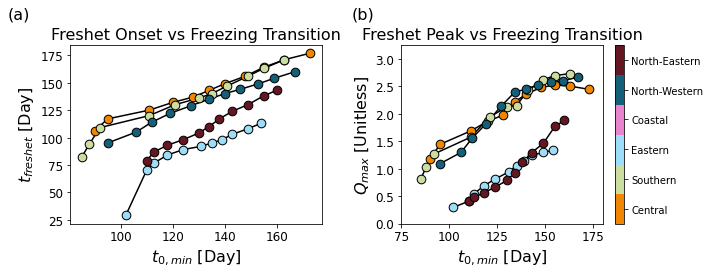

In [169]:
saveIt = 0
saveEPS = 0

cmap = matplotlib.colors.ListedColormap(rgbs_array)
bounds = [0,1,2,3,4,5,6]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

for cluster in range(6):
  if cluster != 3:
    x = Tmin_zero_crossings_all[:,cluster] #- Tmin_zero_crossings_all[5,cluster]
    y = t_half[cluster,:] #- t_half[cluster,5]
    ax[0].plot(x, y, color = 'k', zOrder = 0)
    ax[0].scatter(x, y, color = rgbas_array[cluster,:], edgecolor = 'k', s = 75)

ax[0].set_xlabel('$t_{0, min}$ [Day]', fontsize = fs)
ax[0].set_ylabel('$t_{freshet}$ [Day]', fontsize = fs)
ax[0].set_title('Freshet Onset vs Freezing Transition', fontsize = fs)
ax[0].text(x = -0.25, y = 1.15, s = '(a)', transform = ax[0].transAxes, fontsize = fs)
ax[0].tick_params(labelsize = fs-4)

for cluster in range(6):
  if cluster != 3:
    x = Tmin_zero_crossings_all[:,cluster] #- Tmin_zero_crossings_all[5,cluster]
    y = q_peak[cluster,:] #- t_half[cluster,5]
    ax[1].plot(x, y, color = 'k', zOrder = 0)
    ax[1].scatter(x, y, color = rgbas_array[cluster,:], edgecolor = 'k', s = 75)

s = ax[1].scatter([0,1,2,4,5],[0,1,2,4,5], c=[0,1,2,4,5], cmap = cmap, norm = norm) #just for colourmap

ax[1].set_xlabel('$t_{0, min}$ [Day]', fontsize = fs)
ax[1].set_ylabel('$Q_{max}$ [Unitless]', fontsize = fs)
ax[1].set_title('Freshet Peak vs Freezing Transition', fontsize = fs)
ax[1].tick_params(labelsize = fs-4)
ax[1].set_xlim((75,180))
ax[1].set_ylim((0,3.25))
ax[1].text(x = -0.25, y = 1.15, s = '(b)', transform = ax[1].transAxes, fontsize = fs)

cb = fig.colorbar(s, ax = ax[1])
cb.set_ticks(np.arange(0.5,6.5,1))
cb.set_ticklabels(['Central', 'Southern', 'Eastern', 'Coastal', 'North-Western', 'North-Eastern'])

plt.tight_layout()

if saveIt:
  plt.savefig('freshet_timing_and_peak_vs_freezing.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('freshet_timing_and_peak_vs_freezing.eps', format = 'eps', bbox_inches='tight')


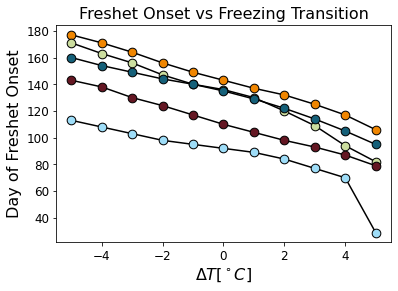

In [ ]:
saveIt = 0
saveEPS = 0

fig, ax = plt.subplots()

for cluster in range(6):
  if cluster != 3:
    x = heat_increments_min*Tminstd_train #Tmin_zero_crossings_all[:,cluster] #- Tmin_zero_crossings_all[5,cluster]
    y = t_half[cluster,:] #- t_half[cluster,5]
    ax.plot(x, y, color = 'k', zOrder = 0)
    ax.scatter(x, y, color = rgbas_array[cluster,:], edgecolor = 'k', s = 75)

ax.set_xlabel('$\Delta T [^\circ C]$', fontsize = fs)
ax.set_ylabel('Day of Freshet Onset', fontsize = fs)
ax.set_title('Freshet Onset vs Freezing Transition', fontsize = fs)
ax.tick_params(labelsize = fs-4)

if saveIt:
  plt.savefig('freshet_timing_vs_dT.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('freshet_timing_vs_dT.eps', format = 'eps', bbox_inches='tight')

# Figures

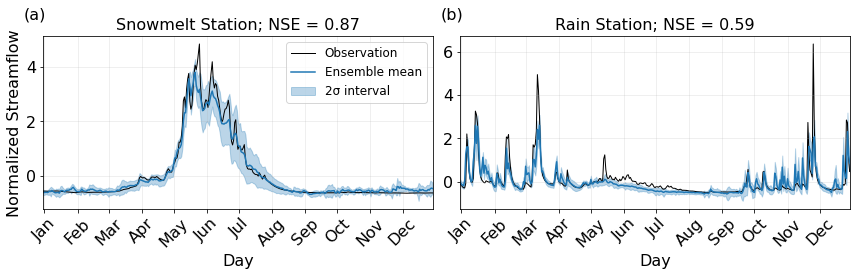

In [57]:
##### examples of streamflow

saveIt = 0
saveEPS = 0

snowy_cluster = 1
rainy_cluster = 3

snowy_cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==snowy_cluster))
rainy_cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==rainy_cluster))

sorted_snowy = np.mean(NSE_fine_runs, axis = 0)[snowy_cluster_inds].argsort()
sorted_rainy = np.mean(NSE_fine_runs, axis = 0)[rainy_cluster_inds].argsort()

sss = 5
snowy_ind = snowy_cluster_inds[sorted_snowy[-sss]] #take 5th 'best' station
rainy_ind = rainy_cluster_inds[sorted_rainy[-sss]]

days = range(365*2, 365*3)
days = range(Ntest)
days = range(365)

y_test_runs_snowy = y_test_predict_fine_runs[:,:,snowy_ind]
y_test_runs_rainy = y_test_predict_fine_runs[:,:,rainy_ind]

y_err_snowy = 2*np.std(y_test_runs_snowy, axis = 0)
y_mean_snowy = np.mean(y_test_runs_snowy, axis = 0)

y_err_rainy = 2*np.std(y_test_runs_rainy, axis = 0)
y_mean_rainy = np.mean(y_test_runs_rainy, axis = 0)

x_days = np.arange(len(y_mean_snowy))

fb1_snowy = y_mean_snowy - y_err_snowy
fb2_snowy = y_mean_snowy + y_err_snowy

fb1_rainy = y_mean_rainy - y_err_rainy
fb2_rainy = y_mean_rainy + y_err_rainy

rgb = '#1f77b4' #colour for shading that I like (picked from coolors.co)

fs = 16 #fontsize

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].plot(days, y_test.numpy()[days,snowy_ind], label = 'Observation', color = 'k', linewidth = 1)
ax[0].fill_between(days, fb1_snowy[days], fb2_snowy[days], alpha = 0.3, label = '2\u03C3 interval', color = rgb)
ax[0].plot(y_mean_snowy[days], label = 'Ensemble mean', color = rgb, linewidth = 1.5)
ax[0].set_ylabel('Normalized Streamflow', fontsize = fs)
ax[0].set_xlabel('Day', fontsize = fs)
ax[0].set_title('Snowmelt Station; NSE = ' + str(np.round(NSE_fine[snowy_ind], decimals = 2)), fontsize = fs)
ax[0].set_xticks(first_days_of_month)
ax[0].set_xlim((0,364))
ax[0].set_xticklabels(months_str, rotation = 45)#, ha = 'right')
ax[0].tick_params(labelsize = fs)
ax[0].legend(fontsize = fs-4)
ax[0].text(x = -0.05, y = 1.1, s = '(a)', transform = ax[0].transAxes, fontsize = fs)
ax[0].grid(True, alpha = 0.25)

ax[1].plot(days, y_test.numpy()[days,rainy_ind], color = 'k', linewidth = 1, zorder = 1)
ax[1].fill_between(days, fb1_rainy[days], fb2_rainy[days], alpha = 0.3, color = rgb, zorder = 0)
ax[1].plot(days, y_mean_rainy[days], color = rgb, linewidth = 1.5, zorder = 2)
ax[1].set_xlabel('Day', fontsize = fs)
ax[1].set_title('Rain Station; NSE = ' + str(np.round(NSE_fine[rainy_ind], decimals = 2)), fontsize = fs)
ax[1].set_xticks(first_days_of_month)
ax[1].set_xlim((0,364))
ax[1].set_xticklabels(months_str, rotation = 45)#, ha = 'right')
ax[1].tick_params(labelsize = fs)
ax[1].text(x = -0.05, y = 1.1, s = '(b)', transform = ax[1].transAxes, fontsize = fs)
ax[1].grid(True, alpha = 0.25)

fig.tight_layout()

if saveIt:
  plt.savefig('streamflow_ensemble_examples.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('streamflow_ensemble_examples.eps', format = 'eps', bbox_inches='tight')

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


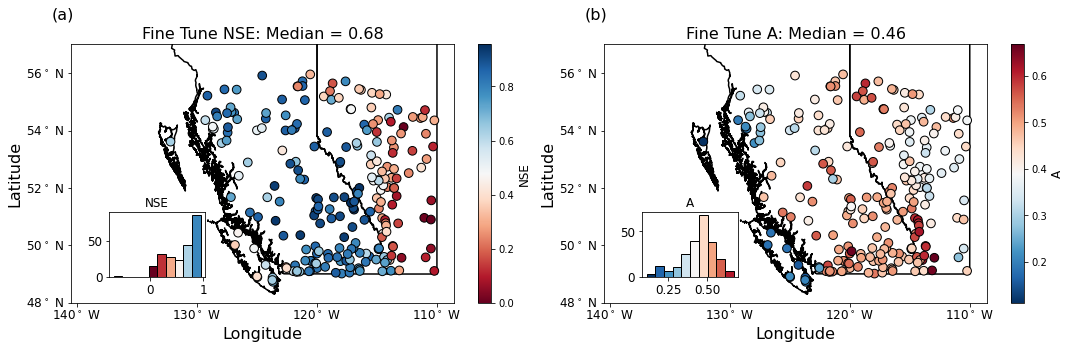

In [58]:
#Visualize NSE and A in space for all stations

saveIt = 0
saveEPS = 0

fs = 16

fig, ax_maps = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

########## NSE in space

##### map of NSE

# ax_map = fig.add_subplot(1,1,1)

vmin = 0
vmax = np.max(NSE_fine)
plot_prov_ax(prov = prov, ax = ax_maps[0])
s = ax_maps[0].scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_fine, s = 75, zOrder = 3, edgecolor = 'k', cmap = 'RdBu', vmin = vmin, vmax = vmax)
cb = plt.colorbar(s, ax = ax_maps[0])#, orientation = 'horizontal')
cb.set_label('NSE', fontsize = 12)
ax_maps[0].set_ylim((48,57))
ax_maps[0].tick_params(labelsize = fs)
ax_maps[0].set_xlabel('Longitude', fontsize = fs)
ax_maps[0].set_ylabel('Latitude', fontsize = fs)
ax_maps[0].set_title('Fine Tune NSE: Median = ' + str(np.round(np.median(NSE_fine), decimals = 2)), fontsize = fs)
ax_maps[0].text(x = -0.05, y = 1.1, s = '(a)', transform = ax_maps[0].transAxes, fontsize = fs)
ax_maps[0].set_xticks(np.arange(-140,-100,10))

##### histogram of NSE

ax_hist_NSE = plt.axes([0,0,1,1], label = 'NSE_hist')
ip = InsetPosition(ax_maps[0], [0.1,0.1,0.25,0.25])
ax_hist_NSE.set_axes_locator(ip)

mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist_NSE.hist(NSE_fine, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_hist_NSE.set_title('NSE', fontsize = fs-4)
#ax_hist_NSE.set_ylabel('Frequency', fontsize = fs-4)
ax_hist_NSE.set_frame_on = False
ax_hist_NSE.tick_params(labelsize = fs-4)


########## A in space

##### map of A

# ax_map = fig.add_subplot(1,1,1)

vmin = np.min(A_fine)
vmax = np.max(A_fine)
plot_prov_ax(prov = prov, ax = ax_maps[1])
s = ax_maps[1].scatter(stationLon[stationInds], stationLat[stationInds], c = A_fine, s = 75, zOrder = 3, edgecolor = 'k', cmap = 'RdBu_r', vmin = vmin, vmax = vmax)
cb = plt.colorbar(s, ax = ax_maps[1])#, orientation = 'horizontal')
cb.set_label('A', fontsize = 12)
ax_maps[1].set_ylim((48,57))
ax_maps[1].tick_params(labelsize = fs)
ax_maps[1].set_xlabel('Longitude', fontsize = fs)
ax_maps[1].set_ylabel('Latitude', fontsize = fs)
ax_maps[1].set_title('Fine Tune A: Median = ' + str(np.round(np.median(A_fine), decimals = 2)), fontsize = fs)
ax_maps[1].text(x = -0.05, y = 1.1, s = '(b)', transform = ax_maps[1].transAxes, fontsize = fs)
ax_maps[1].set_xticks(np.arange(-140,-100,10))

##### histogram of A

ax_hist_A = plt.axes([0,0,1,1], label = 'A_hist')
ip = InsetPosition(ax_maps[1], [0.1,0.1,0.25,0.25])
ax_hist_A.set_axes_locator(ip)

mapname = 'RdBu_r'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist_A.hist(A_fine, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_hist_A.set_title('A', fontsize = fs-4)
#ax_hist_A.set_ylabel('Frequency', fontsize = fs-4)
ax_hist_A.set_frame_on = False
ax_hist_A.tick_params(labelsize = fs-4)

fig.tight_layout()

xtls = [item.get_text()[1:] + '$^\circ$ W' for item in ax_maps[0].get_xticklabels()]
ax_maps[0].set_xticklabels(xtls, fontsize = 12)
ytls = [item.get_text() + '$^\circ$ N' for item in ax_maps[0].get_yticklabels()]
ax_maps[0].set_yticklabels(ytls, fontsize = 12)

xtls = [item.get_text()[1:] + '$^\circ$ W' for item in ax_maps[1].get_xticklabels()]
ax_maps[1].set_xticklabels(xtls, fontsize = 12)
ytls = [item.get_text() + '$^\circ$ N' for item in ax_maps[1].get_yticklabels()]
ax_maps[1].set_yticklabels(ytls, fontsize = 12)

if saveIt:
  plt.savefig('NSE_A_map_hist.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('NSE_A_map_hist.eps', format = 'eps', bbox_inches='tight')

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


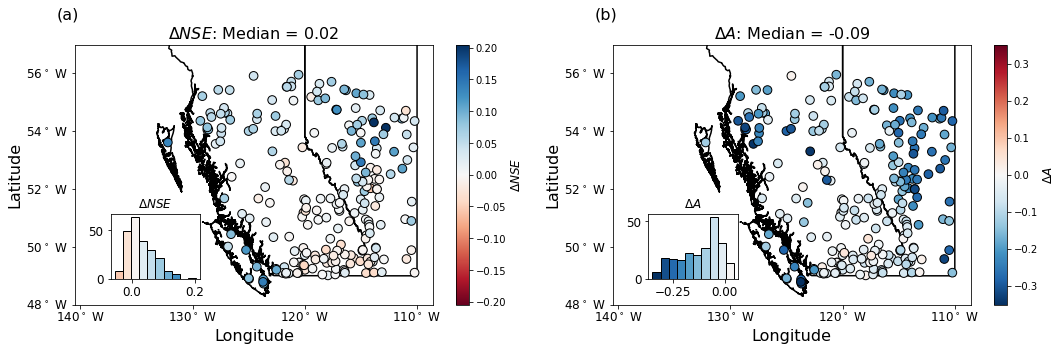

In [59]:
#Visualize \DeltaNSE and \DeltaA in space for all stations

saveIt = 0
saveEPS = 0

fs = 16

fig, ax_maps = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

dNSE = NSE_fine - NSE_bulk
dNSE_crop = np.sort(dNSE)[:-1] #dNSE w/ largest removed (largest > 1, 2nd largest <0.3; remove largest for readability)
dA = A_fine - A_bulk

########## dNSE in space

##### map of dNSE

vmax = np.max(np.abs(dNSE_crop))
vmin = -vmax
plot_prov_ax(prov = prov, ax = ax_maps[0])
s = ax_maps[0].scatter(stationLon[stationInds], stationLat[stationInds], c = dNSE, s = 75, zOrder = 3, edgecolor = 'k', cmap = 'RdBu', vmin = vmin, vmax = vmax)
cb = plt.colorbar(s, ax = ax_maps[0])#, orientation = 'horizontal')
cb.set_label('$\Delta NSE$', fontsize = 12)
ax_maps[0].set_ylim((48,57))
ax_maps[0].tick_params(labelsize = fs)
ax_maps[0].set_xlabel('Longitude', fontsize = fs)
ax_maps[0].set_ylabel('Latitude', fontsize = fs)
ax_maps[0].set_title('$\Delta NSE$: Median = ' + str(np.round(np.median(dNSE), decimals = 2)), fontsize = fs)
ax_maps[0].text(x = -0.05, y = 1.1, s = '(a)', transform = ax_maps[0].transAxes, fontsize = fs)
ax_maps[0].set_xticks(np.arange(-140,-100,10))

##### histogram of dNSE

ax_hist_NSE = plt.axes([0,0,1,1], label = 'dNSE_hist')
ip = InsetPosition(ax_maps[0], [0.1,0.1,0.25,0.25])
ax_hist_NSE.set_axes_locator(ip)

mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist_NSE.hist(dNSE_crop, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_hist_NSE.set_title('$\Delta NSE$', fontsize = fs-4)
#ax_hist_NSE.set_ylabel('Frequency', fontsize = fs-4)
ax_hist_NSE.set_frame_on = False
ax_hist_NSE.tick_params(labelsize = fs-4)


########## dA in space

##### map of A

vmax = np.max(np.abs(dA))
vmin = -vmax
plot_prov_ax(prov = prov, ax = ax_maps[1])
s = ax_maps[1].scatter(stationLon[stationInds], stationLat[stationInds], c = dA, s = 75, zOrder = 3, edgecolor = 'k', cmap = 'RdBu_r', vmin = vmin, vmax = vmax)
cb = plt.colorbar(s, ax = ax_maps[1])#, orientation = 'horizontal')
cb.set_label('$\Delta A$', fontsize = 12)
ax_maps[1].set_ylim((48,57))
ax_maps[1].tick_params(labelsize = fs)
ax_maps[1].set_xlabel('Longitude', fontsize = fs)
ax_maps[1].set_ylabel('Latitude', fontsize = fs)
ax_maps[1].set_title('$\Delta A$: Median = ' + str(np.round(np.median(dA), decimals = 2)), fontsize = fs)
ax_maps[1].text(x = -0.05, y = 1.1, s = '(b)', transform = ax_maps[1].transAxes, fontsize = fs)
ax_maps[1].set_xticks(np.arange(-140,-100,10))

##### histogram of A

ax_hist_A = plt.axes([0,0,1,1], label = 'dA_hist')
ip = InsetPosition(ax_maps[1], [0.1,0.1,0.25,0.25])
ax_hist_A.set_axes_locator(ip)

mapname = 'RdBu_r'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist_A.hist(dA, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_hist_A.set_title('$\Delta A$', fontsize = fs-4)
#ax_hist_A.set_ylabel('Frequency', fontsize = fs-4)
ax_hist_A.set_frame_on = False
ax_hist_A.tick_params(labelsize = fs-4)

xtls = [str(np.abs(val)) + '$^\circ$ W' for val in np.arange(-140,-100,10)]
ax_maps[0].set_xticklabels(xtls, fontsize = 12)
ytls = [str(val) + '$^\circ$ W' for val in np.arange(48,58,2)]
ax_maps[0].set_yticklabels(ytls, fontsize = 12)

xtls = [str(np.abs(val)) + '$^\circ$ W' for val in np.arange(-140,-100,10)]
ax_maps[1].set_xticklabels(xtls, fontsize = 12)
ytls = [str(val) + '$^\circ$ W' for val in np.arange(48,58,2)]
ax_maps[1].set_yticklabels(ytls, fontsize = 12)

fig.tight_layout()

if saveIt:
  plt.savefig('dNSE_dA_map_hist.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('dNSE_dA_map_hist.eps', format = 'eps', bbox_inches='tight')

plt.show()

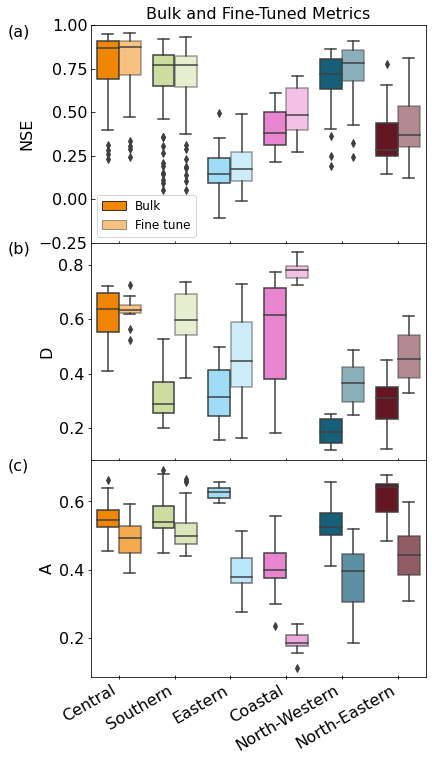

In [60]:
##### NSE, D, and A for bulk and fine-tune all at once

saveIt = 0
saveEPS = 0

fs = 16 #fontsize

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (6,12))


#################### NSE

#x: cluster labels; y: NSE; hue: bulk/fine
boxx_bulk = seasonal_clustering.labels_ 
boxx_fine = seasonal_clustering.labels_

# boxy_bulk = np.mean(NSE_bulk_runs, axis = 0) #average NSE across model runs for each station
# boxy_fine = np.mean(NSE_fine_runs, axis = 0)

boxy_bulk = NSE_bulk
boxy_fine = NSE_fine
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dNSE))], ['Fine tune' for kk in range(len(dNSE))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = axes[0])
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5) #fine-tuned boxes set partially transparent

axes[0].set_ylabel('NSE', fontsize = fs)
axes[0].set_title('Bulk and Fine-Tuned Metrics', fontsize = fs)
axes[0].tick_params(labelsize = fs, labelbottom = False, direction = 'in')
axes[0].tick_params(axis = 'x', direction = 'inout')
#axes[0].set_ylim((-0.5,1))
axes[0].set_ylim((-0.25,1))
axes[0].text(x = -0.25, y = 0.95, s = '(a)', transform = axes[0].transAxes, fontsize = fs)

leg = axes[0].legend(loc = 'lower left', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')


#################### A

#x: cluster labels; y: A; hue: bulk/fine
# boxy_bulk = np.empty(np.shape(boxx_bulk)) 
# boxy_fine = np.empty(np.shape(boxx_fine))

# boxy_bulk = np.mean(A_bulk_runs, axis = 0) #average A across model runs for each station
# boxy_fine = np.mean(A_fine_runs, axis = 0)
  
boxy_bulk = A_bulk
boxy_fine = A_fine

boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dA))], ['Fine tune' for kk in range(len(dA))]))
bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = axes[2])
bp.get_legend().remove()
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.7) #fine-tuned boxes set partially transparent

axes[2].set_ylabel('A', fontsize = fs)
axes[2].tick_params(labelsize = fs)
axes[2].tick_params(axis = 'x', direction = 'inout')
axes[2].text(x = -0.25, y = 0.95, s = '(c)', transform = axes[2].transAxes, fontsize = fs)
axes[2].set_xticklabels(cluster_names, rotation = 30, ha = 'right')


################# D

n_runs = len(runs)

boxx_bulk = np.tile(np.arange(0,6), (n_runs,))
boxx_fine = np.tile(np.arange(0,6), (n_runs,))

boxy_bulk = np.empty(np.shape(boxx_bulk))
boxy_fine = np.empty(np.shape(boxx_fine))

start = 0
for run in range(n_runs):
  fin = start + 6
  boxy_bulk[start:fin] = ks_bulk[run,:]
  boxy_fine[start:fin] = ks_fine[run,:]
  start = fin
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(boxx_bulk))], ['Fine tune' for kk in range(len(boxx_fine))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = axes[1])
bp.get_legend().remove()
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5)

axes[1].set_ylabel('D', fontsize = fs)
axes[1].tick_params(labelsize = fs)
axes[1].tick_params(axis = 'x', direction = 'inout')
axes[1].text(x = -0.25, y = 0.95, s = '(b)', transform = axes[1].transAxes, fontsize = fs)

plt.subplots_adjust(hspace = 0)

if saveIt:
  plt.savefig('NSE_A_D_bulk_fine.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('NSE_A_D_bulk_fine.eps', format = 'eps', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


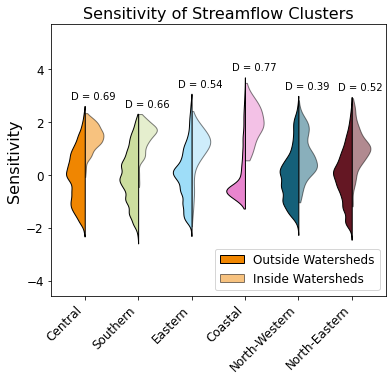

In [61]:
#inside/outside sensitivity distributions w/ D -- fine ensemble
#help from: https://stackoverflow.com/questions/29776114/half-violin-plot

saveIt = 0
saveEPS = 0

fs = 16

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

parts_in = ax.violinplot(dataset = heat_in_clusters_fine_ensemble, showextrema = False, widths = 0.7, positions = range(6))
parts_out = ax.violinplot(dataset = heat_out_clusters_fine_ensemble, showextrema = False, widths = 0.7, positions = range(6))

for cluster in range(n_clusters_seasonal):

  part_in = parts_in['bodies'][cluster]
  part_out = parts_out['bodies'][cluster]

  part_out.set_facecolor(rgbas_array[cluster])
  part_out.set_edgecolor('k')
  part_out.set_alpha(1)

  part_in.set_facecolor(rgbas_array[cluster])
  part_in.set_edgecolor('k')
  part_in.set_alpha(0.5)

  m = np.mean(part_out.get_paths()[0].vertices[:, 0])
  part_out.get_paths()[0].vertices[:, 0] = np.clip(part_out.get_paths()[0].vertices[:, 0], -np.inf, m)

  m = np.mean(part_in.get_paths()[0].vertices[:, 0])
  part_in.get_paths()[0].vertices[:, 0] = np.clip(part_in.get_paths()[0].vertices[:, 0], m, np.inf)

  textx = cluster - 0.25
  texty = np.max([part_in.get_paths()[0].vertices[:, 1], part_out.get_paths()[0].vertices[:, 1]]) + 0.25
  ax.text(x = textx, y = texty, s = 'D = ' + str(ks_fine_ensemble[cluster])[:4])

ax.set_ylabel('Sensitivity', fontsize = fs)
ax.set_title('Sensitivity of Streamflow Clusters', fontsize = fs)
ax.set_xticklabels([''] + cluster_names, rotation = 45, ha = 'right')
ax.tick_params(labelsize = fs-4)

ymin = np.min(np.min(np.asarray(heat_out_clusters_fine_ensemble))) - 2
ymax = np.max(np.max(np.asarray(heat_out_clusters_fine_ensemble))) + 2

ax.set_ylim((ymin,ymax))
ax.legend([parts_out['bodies'][0], parts_in['bodies'][0]], ['Outside Watersheds', 'Inside Watersheds'], fontsize = fs-4, loc = 'lower right')

if saveIt:
  plt.savefig('heat_in_out_dist_ensemble.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('heat_in_out_dist_ensemble.eps', format = 'eps', bbox_inches='tight')

plt.show()

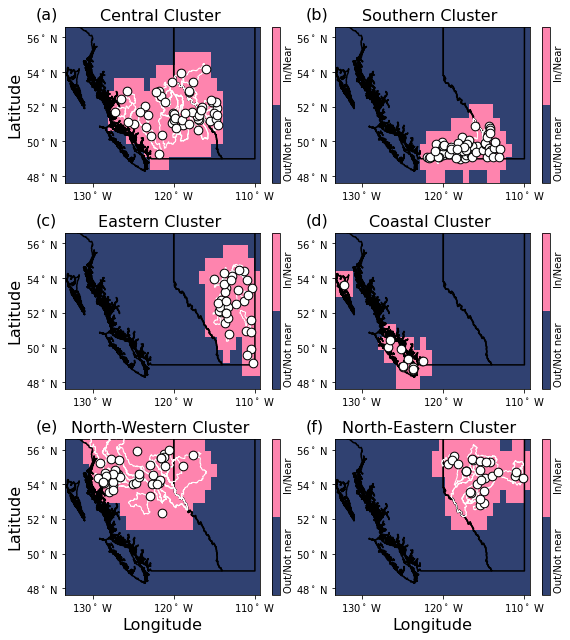

In [62]:
### figure: in/out regions around cluster basins

saveIt = 0
saveEPS = 0

fs = 16

rgba_binary = np.array([[49, 66, 114, 256], #colours of in/near and out/far from watersheds: from coolors.co
              [255, 133, 175, 256]]) / 256
abc = ['(a)','(b)','(c)','(d)','(e)','(f)'] #for labelling subplots

cmap = matplotlib.colors.ListedColormap(rgba_binary)
bounds = [0,0.5,1]
norm_binary = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

nrows = int(np.ceil(n_clusters_seasonal/2))
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for cluster, ax in enumerate(np.squeeze(np.reshape(axes,(-1,1)))):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  binary_in = np.zeros(np.size(Tmax[0]))
  binary_in[unique_in_clusters[cluster]] = 1

  im = ax.imshow(binary_in.reshape(np.shape(Tmax[0])), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm_binary)    

  for ind in inds:
    basin = stationBasins[ind]
    if basin is not None:
      x,y = basin.exterior.xy
      ax.plot(x,y,'w', linewidth = 1, zOrder = 3)

  ax.scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4)
  plot_prov_ax(prov = prov, ax = ax)
  ax.tick_params(labelsize = fs-4)
  if cluster == 4 or cluster == 5:
    ax.set_xlabel('Longitude', fontsize = fs)
  if cluster == 0 or cluster == 2 or cluster == 4:
    ax.set_ylabel('Latitude', fontsize = fs)
  ax.set_title(cluster_names[cluster] + ' Cluster ', fontsize = fs)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))
  ax.tick_params(labelsize = fs-4)
  ax.text(x = -0.15, y = 1.05, s = abc[cluster], transform = ax.transAxes, fontsize = fs)
  ax.set_xticks(np.arange(-130,-100,10))

  cb1 = plt.colorbar(im, ax = ax)
  cb1.set_label(label = 'Out/Not near           In/Near     ')
  cb1.set_ticks([])

fig.tight_layout()

for ax in axes.flatten():
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls, fontsize = 10)

  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls, fontsize = 10)

if saveIt:
  plt.savefig('cluster_shed_in_out.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('cluster_shed_in_out.eps', format = 'eps', bbox_inches='tight')

plt.show()

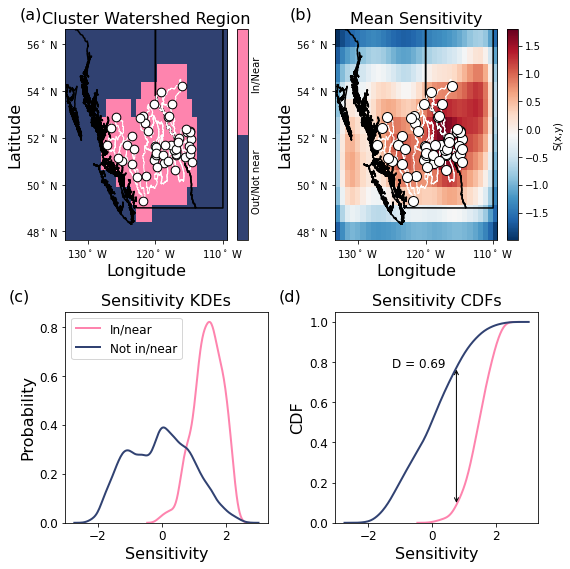

In [63]:
#figure: one cluster heat + one cluster in/out + distributions + cdf

saveIt = 0
saveEPS = 0

cluster = 0

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))

### cluster in/out
inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

binary_in = np.zeros(np.size(Tmax[0]))
binary_in[unique_in_clusters[cluster]] = 1

im = ax[0,0].imshow(binary_in.reshape(np.shape(Tmax[0])), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm_binary)    

for ind in inds:
  basin = stationBasins[ind]
  if basin is not None:
    x,y = basin.exterior.xy
    ax[0,0].plot(x,y,'w', linewidth = 1, zOrder = 3)

ax[0,0].scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4)
plot_prov_ax(prov = prov, ax = ax[0,0])
ax[0,0].tick_params(labelsize = fs-4)
ax[0,0].set_xlabel('Longitude', fontsize = fs)
ax[0,0].set_ylabel('Latitude', fontsize = fs)
ax[0,0].set_title('Cluster Watershed Region', fontsize = fs)
ax[0,0].set_xlim((extentERA[0],extentERA[1]))
ax[0,0].set_ylim((extentERA[2],extentERA[3]))
cb1 = plt.colorbar(im, ax = ax[0,0])
cb1.set_label(label = 'Out/Not near                  In/Near')
cb1.set_ticks([])
ax[0,0].text(x = -0.28, y = 1.05, s = '(a)', transform = ax[0,0].transAxes, fontsize = fs)

### cluster heat
inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
heat_cluster = np.mean(heat_fine_ensemble_mean[:,inds], axis = 1)

im = ax[0,1].imshow(heat_cluster.reshape(np.shape(Tmax[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)     

for ind in inds:
  basin = stationBasins[ind]
  if basin is not None:
    x,y = basin.exterior.xy
    ax[0,1].plot(x,y,'w', linewidth = 1, zOrder = 3)

ax[0,1].scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 100, facecolor = 'w', edgecolor = 'k', zOrder = 4)
plot_prov_ax(prov = prov, ax = ax[0,1])
ax[0,1].tick_params(labelsize = fs-4)
ax[0,1].set_xlabel('Longitude', fontsize = fs)
ax[0,1].set_ylabel('Latitude', fontsize = fs)
ax[0,1].set_title('Mean Sensitivity', fontsize = fs)
ax[0,1].set_xlim((extentERA[0],extentERA[1]))
ax[0,1].set_ylim((extentERA[2],extentERA[3]))
cb2 = plt.colorbar(im, ax = ax[0,1])
cb2.set_label(label = 'S(x,y)')
ax[0,1].text(x = -0.28, y = 1.05, s = '(b)', transform = ax[0,1].transAxes, fontsize = fs)

### distributions 
sns.kdeplot(heat_in_clusters_fine_ensemble[cluster], ax = ax[1,0], label = 'In/near', color = rgba_binary[1], linewidth = 2)
sns.kdeplot(heat_out_clusters_fine_ensemble[cluster], ax = ax[1,0], label = 'Not in/near', color = rgba_binary[0], linewidth = 2)
ax[1,0].legend(fontsize = fs-4)
ax[1,0].tick_params(labelsize = fs-4)
ax[1,0].set_xlabel('Sensitivity', fontsize = fs)
ax[1,0].set_ylabel('Probability', fontsize = fs)
ax[1,0].set_title('Sensitivity KDEs', fontsize = fs)
ax[1,0].text(x = -0.28, y = 1.05, s = '(c)', transform = ax[1,0].transAxes, fontsize = fs)

### cdf
cdf_in = sns.kdeplot(heat_in_clusters_fine_ensemble[cluster], ax = ax[1,1], cumulative = True, color = rgba_binary[1], linewidth = 2, )
cdf_out = sns.kdeplot(heat_out_clusters_fine_ensemble[cluster], ax = ax[1,1], cumulative = True, color = rgba_binary[0], linewidth = 2)

cdf_xin_data = cdf_in.get_children()[0].get_xdata()
cdf_xout_data = cdf_out.get_children()[1].get_xdata()
cdf_in_data = cdf_in.get_children()[0].get_ydata()
cdf_out_data = cdf_out.get_children()[1].get_ydata()

#interpolate onto same x-axis
from scipy.interpolate import interp1d
x1 = np.max([np.min(cdf_xout_data),np.min(cdf_xin_data)])
x2 = np.min([np.max(cdf_xout_data),np.max(cdf_xin_data)])
cdf_x = np.linspace(x1,x2, num = 100)
f_in = interp1d(cdf_xin_data, cdf_in_data)
cdf_in = f_in(cdf_x)
f_out = interp1d(cdf_xout_data, cdf_out_data)
cdf_out = f_out(cdf_x)

d = np.abs(cdf_in - cdf_out) #not on same x axis, can't just subtract!

p1 = [cdf_x[np.argmax(d)], cdf_in[np.argmax(d)]]
p2 = [cdf_x[np.argmax(d)], cdf_out[np.argmax(d)]]
pmid = np.mean([p1, p2], axis = 0)

plt.annotate(s='', xy=(p2[0],p2[1]), xytext=(p1[0],p1[1]), arrowprops=dict(arrowstyle='<->'))
ax[1,1].text(x = p2[0]-2, y = p2[1], s = 'D = ' + str(ks_fine_ensemble[cluster])[:4], fontsize = fs-4)

ax[1,1].tick_params(labelsize = fs-4)
ax[1,1].set_xlabel('Sensitivity', fontsize = fs)
ax[1,1].set_ylabel('CDF', fontsize = fs)
ax[1,1].set_title('Sensitivity CDFs', fontsize = fs)
ax[1,1].text(x = -0.28, y = 1.05, s = '(d)', transform = ax[1,1].transAxes, fontsize = fs)

fig.tight_layout()

for a in ax.flatten()[:2]:
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in a.get_xticklabels()]
  a.set_xticklabels(xtls, fontsize = 10)

  ytls = [item.get_text() + '$^\circ$ N' for item in a.get_yticklabels()]
  a.set_yticklabels(ytls, fontsize = 10)

if saveIt:
  plt.savefig('shed_heat_KDE_CDF_ensemble.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('shed_heat_KDE_CDF_ensemble.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [ ]:
#perturb streamflow -- all models/clusters to visualize |Q_unperturbed - Q_perturbed| in space for a given perturbation
day = 214
kk = 1

#number of iterations of perturbations for one forward pass through model
iters = 1

y_all = np.zeros((2,226,10))

H = np.shape(x_test)[2] #height of input video, in pixels
W = np.shape(x_test)[3] #width of input video, in pixels

x_int = np.arange(W)
y_int = np.arange(H)

x_mesh, y_mesh = np.meshgrid(x_int, y_int)

sigma = 1.5
pointx = 18
pointy = 6

for kk in range(10):

  for cluster in range(6):

    inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

    #model = tf.keras.models.load_model(dir_models + '/model_bulk_'+str(kk)+'.h5')
    model = tf.keras.models.load_model(dir_models + '/model_fine_' + str(kk) + '_cluster_' + str(cluster) + '.h5')
    
    #make perturbation
    H = np.shape(x_test)[2] #height of input video, in pixels
    W = np.shape(x_test)[3] #width of input video, in pixels

    x_int = np.arange(W)
    y_int = np.arange(H)

    x_mesh, y_mesh = np.meshgrid(x_int, y_int)

    d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
    perturb = np.half([np.exp( -d2 / (2*sigma**2)) for iter in range(iters)])

    perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3)
    perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1)

    xday = x_test[day]
    xday_copy = [xday for val in range(iters)]

    x1 = perturb
    x2 = tf.convert_to_tensor(xday_copy)
    xday_perturb = tf.math.add(x1,x2)

    x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_perturb), axis = 0))
    x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
    y_all[:,inds,kk] = model.predict(x_all_ds)

y_mean = np.mean(y_all, axis = -1)

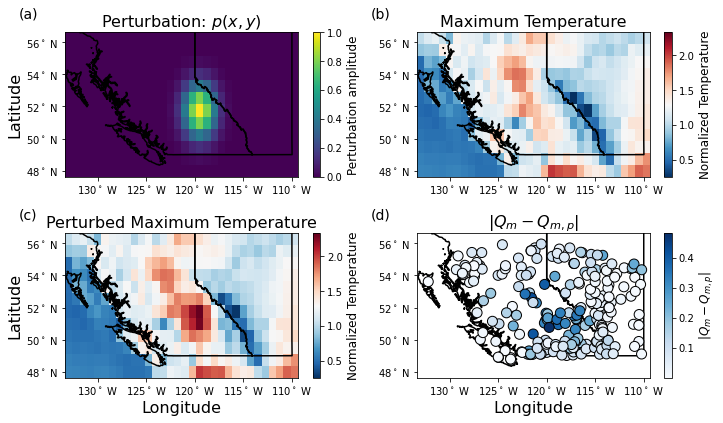

In [152]:
#perturbation + unperturbed temp + perturbed temp

t = np.double(xday.numpy()[0,:,:,0])
t_perturb = np.double(xday_perturb.numpy()[0,0,:,:,0])
dy = np.abs(y_mean[1] - y_mean[0])

vmin = np.min([t,t_perturb])
vmax = np.max([t,t_perturb])

#visualize
saveIt = 0
saveEPS = 0

nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols,3*nrows))

im = axes[0,0].imshow(np.double(perturb[0,0,:,:,0]), aspect = 'auto', extent = extentERA)
plot_prov_ax(prov = prov, ax = axes[0,0])
axes[0,0].set_title('Perturbation: $p(x,y)$', fontsize = fs)
axes[0,0].set_ylabel('Latitude', fontsize = fs)
axes[0,0].set_xlim((extentERA[0], extentERA[1]))
axes[0,0].set_ylim((extentERA[2], extentERA[3]))
axes[0,0].tick_params(labelsize = fs-4)
axes[0,0].text(x = -0.2, y = 1.1, s = '(a)', transform = axes[0,0].transAxes, fontsize = fs-2)
cb = plt.colorbar(im, ax = axes[0,0])
cb.set_label('Perturbation amplitude', fontsize = fs-4)

im = axes[0,1].imshow(t, aspect = 'auto', extent = extentERA, cmap = 'RdBu_r', vmin = vmin, vmax = vmax)
plot_prov_ax(prov = prov, ax = axes[0,1])
axes[0,1].set_title('Maximum Temperature', fontsize = fs)
axes[0,1].set_xlim((extentERA[0], extentERA[1]))
axes[0,1].set_ylim((extentERA[2], extentERA[3]))
axes[0,1].tick_params(labelsize = fs-4)
axes[0,1].text(x = -0.2, y = 1.1, s = '(b)', transform = axes[0,1].transAxes, fontsize = fs-2)
cb = plt.colorbar(im, ax = axes[0,1])
cb.set_label('Normalized Temperature', fontsize = fs-4)

im = axes[1,0].imshow(t_perturb, aspect = 'auto', extent = extentERA, cmap = 'RdBu_r', vmin = vmin, vmax = vmax)
plot_prov_ax(prov = prov, ax = axes[1,0])
axes[1,0].set_title('Perturbed Maximum Temperature', fontsize = fs)
axes[1,0].set_xlabel('Longitude', fontsize = fs)
axes[1,0].set_ylabel('Latitude', fontsize = fs)
axes[1,0].set_xlim((extentERA[0], extentERA[1]))
axes[1,0].set_ylim((extentERA[2], extentERA[3]))
axes[1,0].tick_params(labelsize = fs-4)
axes[1,0].text(x = -0.2, y = 1.1, s = '(c)', transform = axes[1,0].transAxes, fontsize = fs-2)
cb = plt.colorbar(im, ax = axes[1,0])
cb.set_label('Normalized Temperature', fontsize = fs-4)

plot_prov_ax(prov = prov, ax = axes[1,1])
s = axes[1,1].scatter(stationLon[stationInds], stationLat[stationInds], c = dy, s = 100, edgecolor = 'k', cmap = 'Blues', zorder = 3)
axes[1,1].set_xlim((extentERA[0], extentERA[1]))
axes[1,1].set_ylim((extentERA[2], extentERA[3]))
axes[1,1].set_xlabel('Longitude', fontsize = fs)
axes[1,1].set_title('$|Q_m - Q_{m,p}|$', fontsize = fs)
axes[1,1].tick_params(labelsize = fs-4)
axes[1,1].text(x = -0.2, y = 1.1, s = '(d)', transform = axes[1,1].transAxes, fontsize = fs-2)
cb = plt.colorbar(s, ax = axes[1,1])
cb.set_label('$|Q_m - Q_{m,p}|$', fontsize = fs-4)

fig.tight_layout()

for ax in axes.flatten():
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls, fontsize = 10)

  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls, fontsize = 10)

if saveIt:
  plt.savefig('perturbation.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('perturbation.eps', format = 'eps', bbox_inches='tight')

# Additional Figures

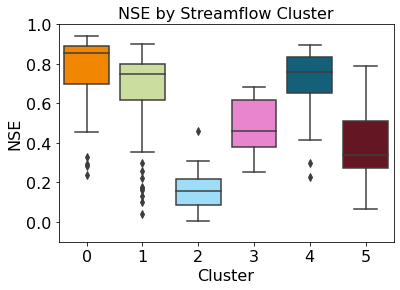

In [64]:
##### NSE: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

fs = 16 #fontsize

fig = plt.figure(figsize = (6,4))

ax_bp = fig.add_subplot(111) #boxplot axis

#x: cluster labels; y: NSE; hue: bulk/fine
#boxx_bulk = seasonal_clustering.labels_ 
boxx_fine = seasonal_clustering.labels_

#boxy_bulk = np.mean(NSE_bulk_runs, axis = 0) #average NSE across model runs for each station
boxy_fine = np.mean(NSE_fine_runs, axis = 0)

bp = sns.boxplot(x = boxx_fine, y = boxy_fine, ax = ax_bp)
for kk in range(n_clusters_seasonal):
  bp.artists[kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters

ax_bp.set_xlabel('Cluster', fontsize = fs)
ax_bp.set_ylabel('NSE', fontsize = fs)
ax_bp.set_title('NSE by Streamflow Cluster', fontsize = fs)
ax_bp.tick_params(labelsize = fs)
ax_bp.set_ylim((-0.1,1))

# ##### histogram of NSE
# ax_hist = plt.axes([0,0,1,1])
# ip = InsetPosition(ax_bp, [0.6,0.15,0.3,0.3])
# ax_hist.set_axes_locator(ip)

# dNSE = boxy_fine - boxy_bulk
# vmax = np.max(np.abs(dNSE)) #centre the colourmap around 0 (so blue = better, red = worse)
# vmin = -vmax
# cmap = cm.get_cmap('RdBu')
# norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
# scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

# n, bins, patches = ax_hist.hist(dNSE, edgecolor = 'k')
# colours = scalarMap.to_rgba(bins)
# for kk, patch in enumerate(patches):
#   patch.set_facecolor(colours[kk])

# ax_hist.set_title('\u0394NSE', fontsize = fs-4)
# ax_hist.set_frame_on = False
# ax_hist.tick_params(labelsize = fs-4)

if saveIt:
  plt.savefig('NSE_ensemble_boxplot.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('NSE_ensemble_boxplot.eps', format = 'eps', bbox_inches='tight')

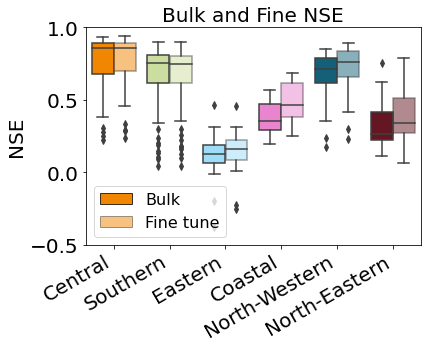

In [65]:
##### NSE: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig = plt.figure(figsize = (6,4))

ax_bp = fig.add_subplot(111) #boxplot axis

#x: cluster labels; y: NSE; hue: bulk/fine
boxx_bulk = seasonal_clustering.labels_ 
boxx_fine = seasonal_clustering.labels_

boxy_bulk = np.mean(NSE_bulk_runs, axis = 0) #average NSE across model runs for each station
boxy_fine = np.mean(NSE_fine_runs, axis = 0)
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dNSE))], ['Fine tune' for kk in range(len(dNSE))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = ax_bp)
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5) #fine-tuned boxes set partially transparent

ax_bp.set_ylabel('NSE', fontsize = fs)
ax_bp.set_title('Bulk and Fine NSE', fontsize = fs)
ax_bp.tick_params(labelsize = fs)
ax_bp.set_xticklabels(cluster_names, rotation = 30, ha = 'right')
ax_bp.set_ylim((-0.5,1))

leg = ax_bp.legend(loc = 'lower left', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

if saveIt:
  plt.savefig('NSE_ensemble_boxplot.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('NSE_ensemble_boxplot.eps', format = 'eps', bbox_inches='tight')

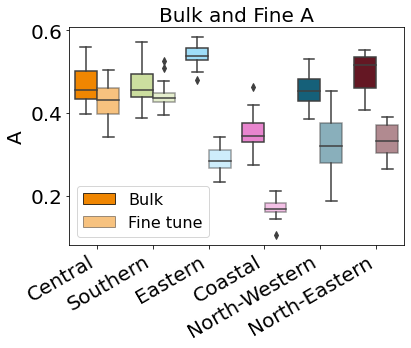

In [66]:
##### A: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4))

#x: cluster labels; y: A; hue: bulk/fine
boxy_bulk = np.empty(np.shape(boxx_bulk)) 
boxy_fine = np.empty(np.shape(boxx_fine))

boxy_bulk = np.mean(A_bulk_runs, axis = 0) #average A across model runs for each station
boxy_fine = np.mean(A_fine_runs, axis = 0)
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dA))], ['Fine tune' for kk in range(len(dA))]))
bp = sns.boxplot(x = boxx, y = boxy, hue = hue)
bp.get_legend().remove()
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5) #fine-tuned boxes set partially transparent

ax.set_xticklabels(cluster_names, rotation = 30, ha = 'right')
ax.set_ylabel('A', fontsize = fs)
ax.set_title('Bulk and Fine A', fontsize = fs)
ax.tick_params(labelsize = fs)
#ax.set_ylim((0,0.6))

leg = ax.legend(loc = 'best', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

if saveIt:
  plt.savefig('A_ensemble_boxplot.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('A_ensemble_boxplot.eps', format = 'eps', bbox_inches='tight')

plt.show()

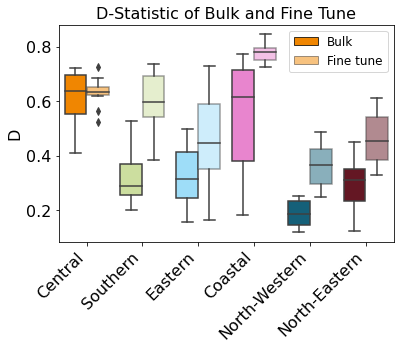

In [67]:
##### D-stat: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

n_runs = len(runs)

fs = 16

fig = plt.figure(figsize = (6,4))

ax_bp = fig.add_subplot(111)

boxx_bulk = np.tile(np.arange(0,6), (n_runs,))
boxx_fine = np.tile(np.arange(0,6), (n_runs,))

##### NSE

boxy_bulk = np.empty(np.shape(boxx_bulk))
boxy_fine = np.empty(np.shape(boxx_fine))

start = 0
for run in range(n_runs):
  fin = start + 6
  boxy_bulk[start:fin] = ks_bulk[run,:]
  boxy_fine[start:fin] = ks_fine[run,:]
  start = fin
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(boxx_bulk))], ['Fine tune' for kk in range(len(boxx_fine))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = ax_bp)
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5)

ax_bp.set_xticklabels(cluster_names, rotation = 45, ha = 'right')
ax_bp.set_ylabel('D', fontsize = fs)
ax_bp.set_title('D-Statistic of Bulk and Fine Tune', fontsize = fs)
ax_bp.tick_params(labelsize = fs)

leg = ax_bp.legend(loc = 'best', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

if saveIt:
  plt.savefig('ks_bulk_fine.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('ks_bulk_fine.eps', format = 'eps', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


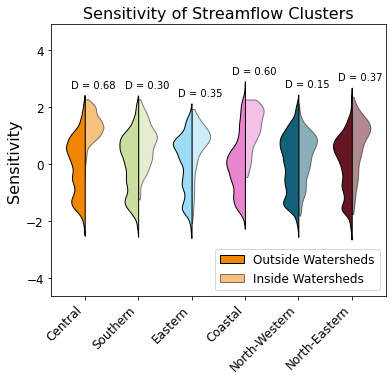

In [68]:
#inside/outside sensitivity distributions w/ D -- bulk ensemble
#help from: https://stackoverflow.com/questions/29776114/half-violin-plot

saveIt = 0
saveEPS = 0

fs = 16

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

parts_in = ax.violinplot(dataset = heat_in_clusters_bulk_ensemble, showextrema = False, widths = 0.7, positions = range(6))
parts_out = ax.violinplot(dataset = heat_out_clusters_bulk_ensemble, showextrema = False, widths = 0.7, positions = range(6))

for cluster in range(n_clusters_seasonal):

  part_in = parts_in['bodies'][cluster]
  part_out = parts_out['bodies'][cluster]

  part_out.set_facecolor(rgbas_array[cluster])
  part_out.set_edgecolor('k')
  part_out.set_alpha(1)

  part_in.set_facecolor(rgbas_array[cluster])
  part_in.set_edgecolor('k')
  part_in.set_alpha(0.5)

  m = np.mean(part_out.get_paths()[0].vertices[:, 0])
  part_out.get_paths()[0].vertices[:, 0] = np.clip(part_out.get_paths()[0].vertices[:, 0], -np.inf, m)

  m = np.mean(part_in.get_paths()[0].vertices[:, 0])
  part_in.get_paths()[0].vertices[:, 0] = np.clip(part_in.get_paths()[0].vertices[:, 0], m, np.inf)

  textx = cluster - 0.25
  texty = np.max([part_in.get_paths()[0].vertices[:, 1], part_out.get_paths()[0].vertices[:, 1]]) + 0.25
  ax.text(x = textx, y = texty, s = 'D = ' + str(ks_bulk_ensemble[cluster])[:4])

ax.set_ylabel('Sensitivity', fontsize = fs)
ax.set_title('Sensitivity of Streamflow Clusters', fontsize = fs)
ax.set_xticklabels([''] + cluster_names, rotation = 45, ha = 'right')
ax.tick_params(labelsize = fs-4)

ymin = np.min(np.min(np.asarray(heat_out_clusters_bulk_ensemble))) - 2
ymax = np.max(np.max(np.asarray(heat_out_clusters_bulk_ensemble))) + 2

ax.set_ylim((ymin,ymax))
ax.legend([parts_out['bodies'][0], parts_in['bodies'][0]], ['Outside Watersheds', 'Inside Watersheds'], fontsize = fs-4, loc = 'lower right')

if saveIt:
  plt.savefig('heat_in_out_dist_ensemble.png', bbox_inches = 'tight', dpi = 300)
if saveEPS:
  plt.savefig('heat_in_out_dist_ensemble.eps', format = 'eps', bbox_inches='tight')

plt.show()

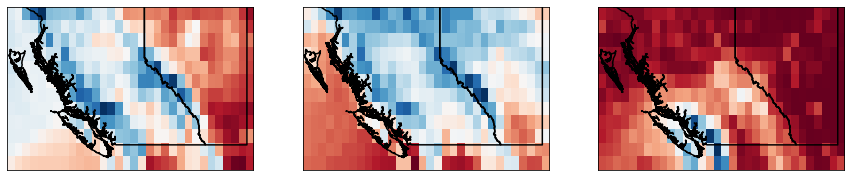

In [69]:
#max temp/min temp + precip for the model architecture figure

saveIt = 0
saveEPS = 0

day = 122
cmaps = ['RdBu_r', 'RdBu_r', 'RdBu'] #temperature: red is high; precip: blue is high

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,3))

for kk, ax in enumerate(axes):
  ax.imshow(np.double(x_test.numpy()[0,day,:,:,kk]), aspect = 'auto', extent = extentERA, cmap = cmaps[kk])
  plot_prov_ax(prov = prov, ax = ax)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))
  ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

if saveIt:
  plt.savefig('input_frame.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('input_frame.eps', format = 'eps', bbox_inches='tight')

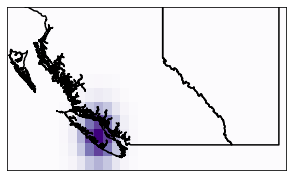

In [70]:
#just perturbation 

saveIt = 0
saveEPS = 0

H = np.shape(x_test)[2] #height of input video, in pixels
W = np.shape(x_test)[3] #width of input video, in pixels

x_int = np.arange(W)
y_int = np.arange(H)

x_mesh, y_mesh = np.meshgrid(x_int, y_int)

sigma = 1.5

pointx = 10
pointy = 9

d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
perturb = np.exp( -d2 / (2*sigma**2))

cmap = 'Purples'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3))

ax.imshow(np.double(perturb), aspect = 'auto', extent = extentERA, cmap = cmap)
plot_prov_ax(prov = prov, ax = ax)
ax.set_xlim((extentERA[0], extentERA[1]))
ax.set_ylim((extentERA[2], extentERA[3]))
ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

if saveIt:
  plt.savefig('just_perturb.png', dpi = 300, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('just_perturb.eps', format = 'eps', bbox_inches='tight')

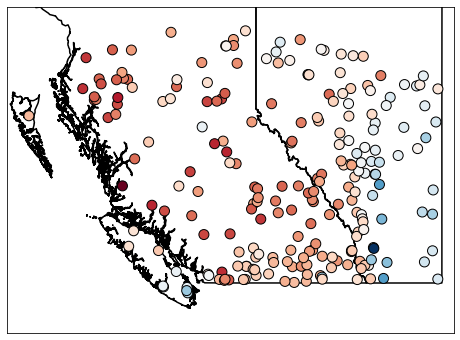

In [71]:
#flow field for the model architecture figure

saveIt = 0
saveEPS = 0

day = 450

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6), frameon = False)
plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], s = 100, linewidth = 1, edgeColor = 'k', c = np.double(y_test.numpy())[day,:], zOrder = 3, cmap = 'RdBu')
ax.set_xlim((extentERA[0], extentERA[1]))
ax.set_ylim((extentERA[2], extentERA[3]))
ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

if saveIt:
  plt.savefig('steam_gauge_locations.png', dpi = 300)
if saveEPS:
  plt.savefig('stream_gauge_locations.eps', format = 'eps', bbox_inches='tight')

plt.show()

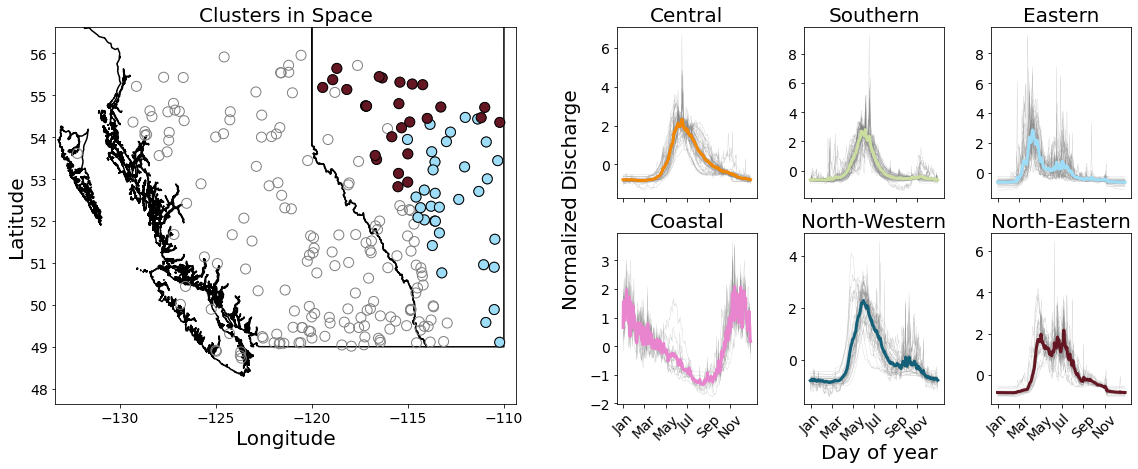

In [72]:
#visualize clustering results for only select clusters (spatial + temporal patterns) -- for AGU talk

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

clusters = [2,5]

fig = plt.figure(figsize = (16,7))

ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], facecolor = [], s = 100, linewidth = 1, edgeColor = 'gray', zOrder = 3)
for cluster in clusters:
  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax0.scatter(stationLon[stationInds][inds], stationLat[stationInds][inds], c = cStations[inds,:], s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = 12)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))
ax0.tick_params(labelsize = fs-6)

subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs-6)
  ax.set_title(cluster_names[cluster], fontsize = fs)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

ax0.text(-107,50, 'Normalized Discharge', fontsize = fs, rotation = 90) #manually add axis labels to control tight-layout aesthetic 
ax0.text(-93.5,46.35, 'Day of year', fontsize = fs)

if saveIt:
  plt.savefig('cluster_patterns_' + str(clusters) + '.png', bbox_inches = 'tight', dpi = 300)

if saveEPS:
  plt.savefig('cluster_patterns_' + str(clusters) + '.eps', format = 'eps', bbox_inches='tight')

plt.show()

# Comparison with process-based models

In [73]:
stations = [
            ' BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER',
            ' ENGLISHMAN RIVER NEAR PARKSVILLE',
            ' LILLOOET RIVER NEAR PEMBERTON',
            ' STUART RIVER NEAR FORT ST. JAMES',
            ' FRASER RIVER AT SHELLEY',
            ' QUESNEL RIVER NEAR QUESNEL',
            ' NORTH THOMPSON RIVER AT MCLURE',
            ' SOUTH THOMPSON RIVER AT CHASE',
            ' THOMPSON RIVER NEAR SPENCES BRIDGE',
            ' HARRISON RIVER NEAR HARRISON HOT SPRINGS',
            ' TSILCOH RIVER NEAR THE MOUTH',
            ' COLUMBIA RIVER AT NICHOLSON',
            ' KICKING HORSE RIVER AT GOLDEN',
            ' KUSKANAX CREEK NEAR NAKUSP',
            ' KASLO RIVER BELOW KEMP CREEK',
            ' COLUMBIA RIVER AT DONALD', 
            ' BARNES CREEK NEAR NEEDLES',
            ' GOLDSTREAM RIVER BELOW OLD CAMP CREEK',
            ' DUNCAN RIVER BELOW B.B. CREEK',
            ' ILLECILLEWAET RIVER AT GREELEY',
            ' MATHER CREEK BELOW HOULE CREEK',
            ' GOLD RIVER ABOVE PALMER CREEK',
            ' ST. MARY RIVER BELOW MORRIS CREEK',
            ' FRY CREEK BELOW CARNEY CREEK',
            ' KEEN CREEK BELOW KYAWATS CREEK',
            ' LEMON CREEK ABOVE SOUTH LEMON CREEK',
            ' SPLIT CREEK AT THE MOUTH',
            ' BEAVER CREEK NEAR BROCKET',
            ' OMINECA RIVER ABOVE OSILINKA RIVER',
            ' PARSNIP RIVER ABOVE MISINCHINKA RIVER',
            ' PINE RIVER AT EAST PINE',
            ' MURRAY RIVER ABOVE WOLVERINE RIVER',
            ' MURRAY RIVER NEAR THE MOUTH',
            ' SUKUNKA RIVER NEAR THE MOUTH',
            ' KICKING HORSE RIVER AT GOLDEN',
            ' COLUMBIA RIVER AT DONALD',
            ' KOOTENAY RIVER AT KOOTENAY CROSSING',
            ' KOOTENAY RIVER AT FORT STEELE',
            ' ELK RIVER AT FERNIE',
            ' ELK RIVER NEAR NATAL',
            ' FORDING RIVER AT THE MOUTH',
            ' SLOCAN RIVER NEAR CRESCENT VALLEY',
            ' SALMO RIVER NEAR SALMO',
            ' MIETTE RIVER NEAR JASPER',
            ' ATHABASCA RIVER NEAR JASPER',
            ' ATHABASCA RIVER AT HINTON',
            ' ATHABASCA RIVER NEAR WINDFALL',
            ' ATHABASCA RIVER AT ATHABASCA',
            ' PEMBINA RIVER AT JARVIE'
]

for station in stations:
  ind = np.squeeze(np.argwhere(stationNames==station))
  xx = y_test[:,ind]
  yy = np.mean(y_test_predict_fine_runs, axis = 0)[:,ind]
  corr = np.corrcoef(xx,yy)[0,1]
  print(station)
  print('     Cluster = ' + str(seasonal_clustering.labels_[ind]))
  print('     NSE = ' + str(np.round(NSE_fine[ind], decimals = 2)))
  print('     Correlation = ' + str(np.round(corr, decimals = 3)))

 BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER
     Cluster = 0
     NSE = 0.94
     Correlation = 0.97
 ENGLISHMAN RIVER NEAR PARKSVILLE
     Cluster = 3
     NSE = 0.59
     Correlation = 0.771
 LILLOOET RIVER NEAR PEMBERTON
     Cluster = 0
     NSE = 0.88
     Correlation = 0.94
 STUART RIVER NEAR FORT ST. JAMES
     Cluster = 4
     NSE = 0.86
     Correlation = 0.944
 FRASER RIVER AT SHELLEY
     Cluster = 4
     NSE = 0.87
     Correlation = 0.951
 QUESNEL RIVER NEAR QUESNEL
     Cluster = 0
     NSE = 0.9
     Correlation = 0.979
 NORTH THOMPSON RIVER AT MCLURE
     Cluster = 0
     NSE = 0.92
     Correlation = 0.979
 SOUTH THOMPSON RIVER AT CHASE
     Cluster = 0
     NSE = 0.91
     Correlation = 0.972
 THOMPSON RIVER NEAR SPENCES BRIDGE
     Cluster = 0
     NSE = 0.93
     Correlation = 0.983
 HARRISON RIVER NEAR HARRISON HOT SPRINGS
     Cluster = 0
     NSE = 0.83
     Correlation = 0.919
 TSILCOH RIVER NEAR THE MOUTH
     Cluster = 4
     NSE = 0.73
     Correlation 